# Forecasting with the FBProphet model

First, I do all the imports I need

In [6]:
import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid
import logging
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


pd.plotting.register_matplotlib_converters()

stat_error_value = 4208130.4301073495

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

df = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')
df['month'] = df.index.month
df['quarter'] = df.index.quarter

cutoff_train_test = 12


# Exploring the data

First I do some basic stats on the data.
I determine that the data isn't very seasonal (at least not that the model can catch) but it has a trend. It can definitely be decomposed into an additive model since the residual noise is just 11%
The data also is not stationary (the stationarity test fails)

 RESMEAN:2709206.45202266, OBSMEAN:23178834.207395833, PERC:11.68827745080559%


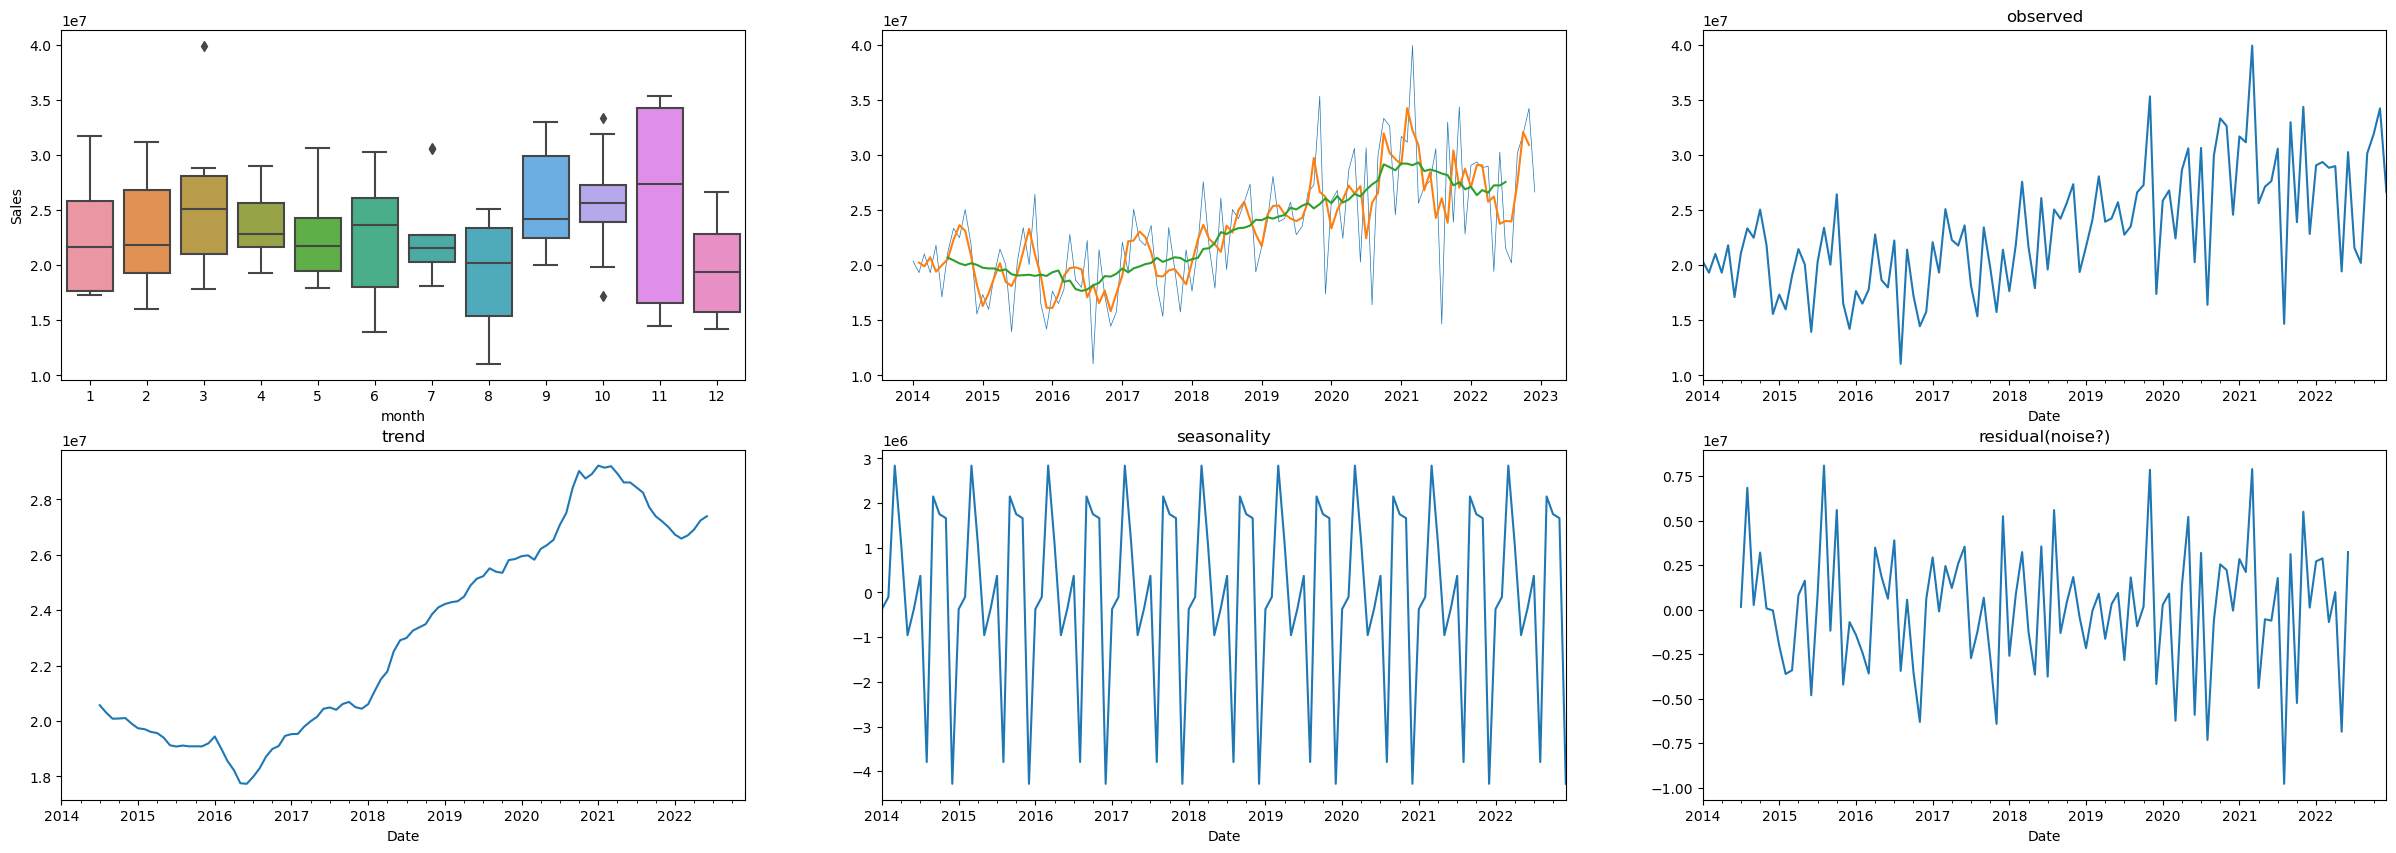

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(30, 10))

sns.boxplot(data=df, x='month', y='Sales', ax=axes[0,0])
df12mean = df['Sales'].rolling(window=12, center=True).mean()
df12std = df['Sales'].rolling(window=12, center=True).std()
df3mean = df['Sales'].rolling(window=3, center=True).mean()
df3std = df['Sales'].rolling(window=3, center=True).std()

axes[0,1].plot(df['Sales'], linewidth=0.5, label='Monthly sales')
axes[0,1].plot(df3mean, label='3-month rolling mean')
axes[0,1].plot(df12mean, label='12 months rolling mean')

result = seasonal_decompose(df['Sales'], period=12, filt=None)
result.trend.plot(ax=axes[1,0], title='trend')
result.seasonal.plot(ax=axes[1,1], title='seasonality')
result.resid.plot(ax=axes[1,2], title='residual(noise?)')
result.observed.plot(ax=axes[0,2], title='observed')

# Decompose time series into additive model
dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
dfs=dfs.dropna()
res=dfs['residuals'].values
obs=dfs['observed'].values
resmean=np.mean(np.abs(res))
obsmean=np.mean(np.abs(obs))
perc=resmean*100/obsmean
print(' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')


# Forecasting using classic methods (SARIMA)

array([<AxesSubplot:title={'center':'Sales'}>], dtype=object)

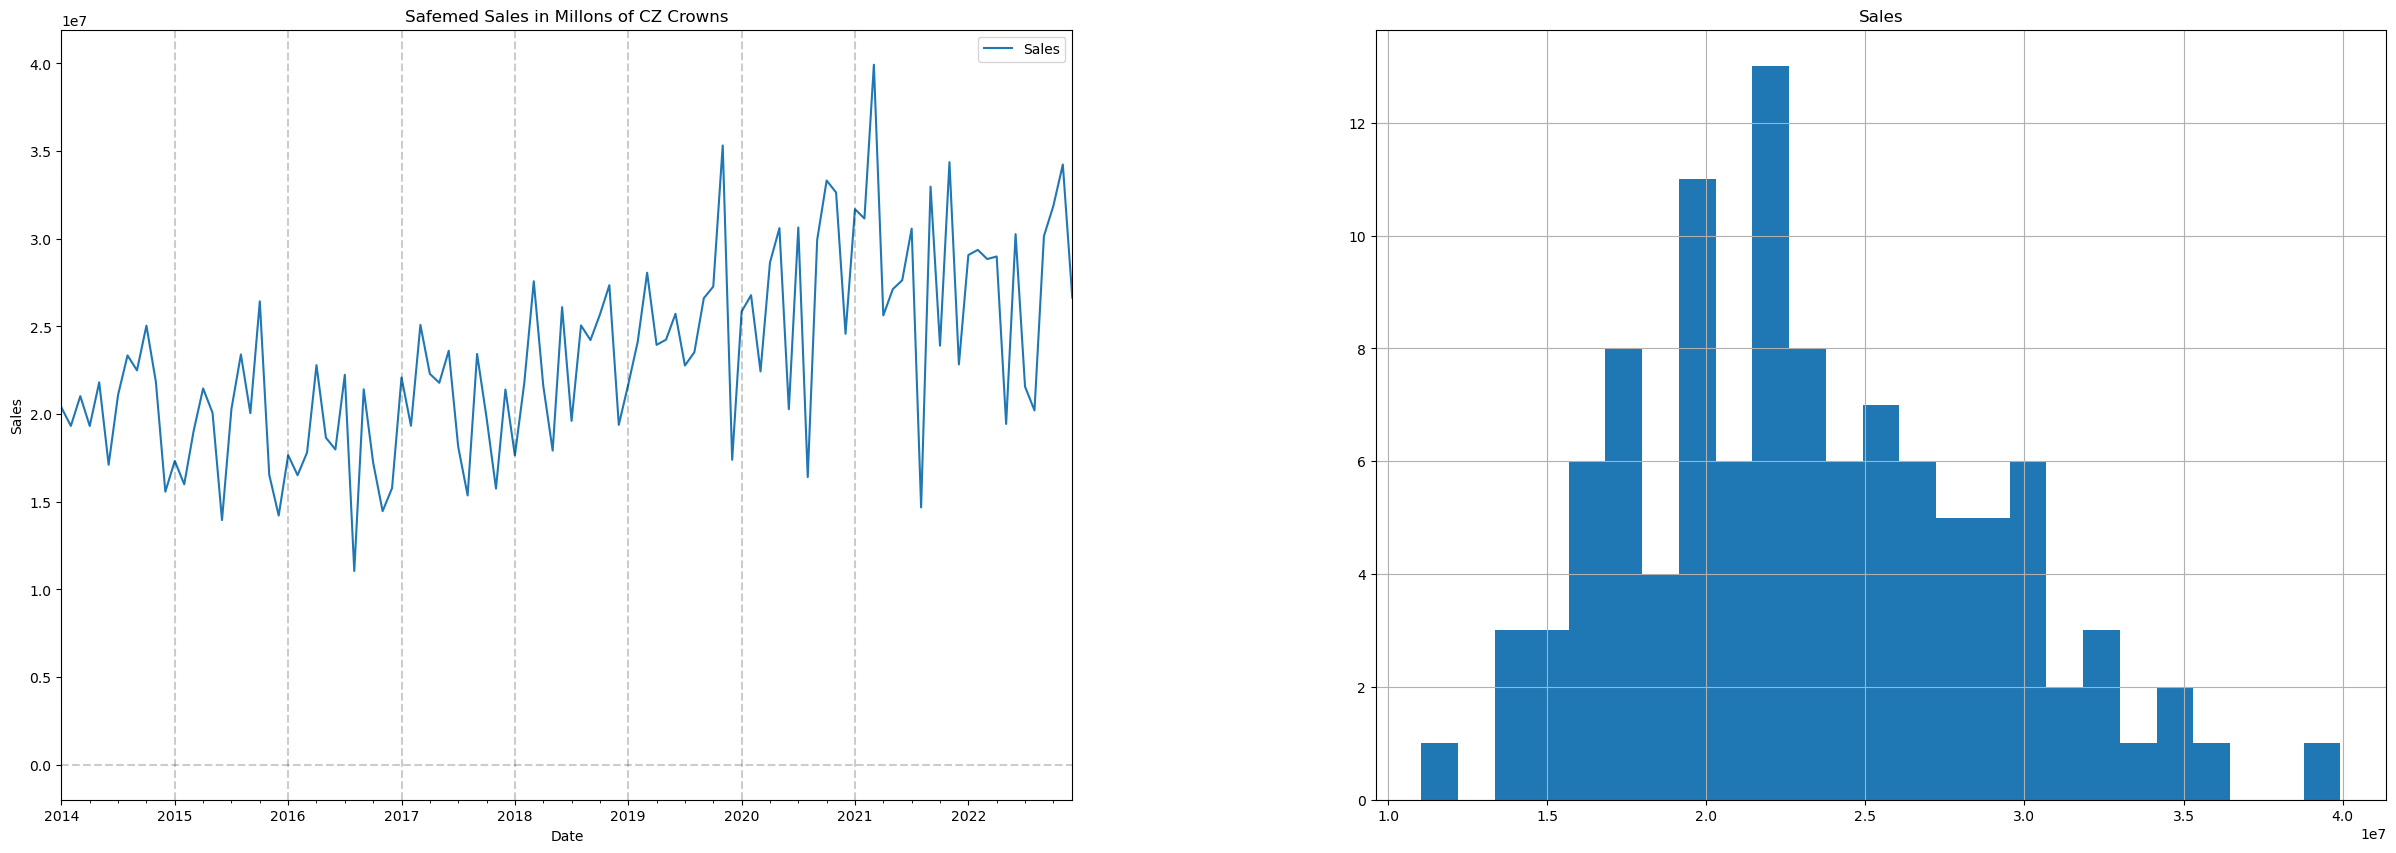

<Figure size 1000x400 with 0 Axes>

In [9]:
df=df[['Sales']]
start_date = df.index.min()
end_date = df.index.max()

# plot the sales data 
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

plt.figure(figsize=(10,4))
df.plot(ax = axes[0], title='Safemed Sales in Millons of CZ Crowns', ylabel='Sales')
for year in range(start_date.year,end_date.year):
    axes[0].axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
axes[0].axhline(0, color='k', linestyle='--', alpha=0.2)
df.hist(bins=25, ax=axes[1])

# We can see that sales of the company is close to a normal distribution. 
# Therefore, we do not have to take log values of the  "sales" 


Clearly, the time series is not stationary, as its mean is not constant through time, and we see an increasing variance in the data, a sign of heteroscedasticity.


Above we can detect weak trend = changing µ
in 2014 -2018 the µ = 2 mln 
from 2019 to 2021 the µ = 2.5 mln 

proving that we are dealing with non stationary time series 

We know that  timeseries has to fulfil 3 main properties ( covariance stationary  processes)

1) E(Yt) = µt =µ   # expected value of Y does not depend on time (constant over time)

2) Cov ( Yt, Yt-1 or future values) # the covariance between Yt and its past or future values also does not depend on time 

3) p(tao) =w(tao)/w(0)= w(tao)/ v(Yt)   # correlation of Yt with its displaced value divided by Yt is also a constant number and it is also does not depend on t 



## Remove the trend in order to obtain a covariance stationary data 


/home/dt/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


p-value of the sales without differencing: 0.8810838871989548
p-value of the sales with first order differencing: 1.3139783701413726e-10


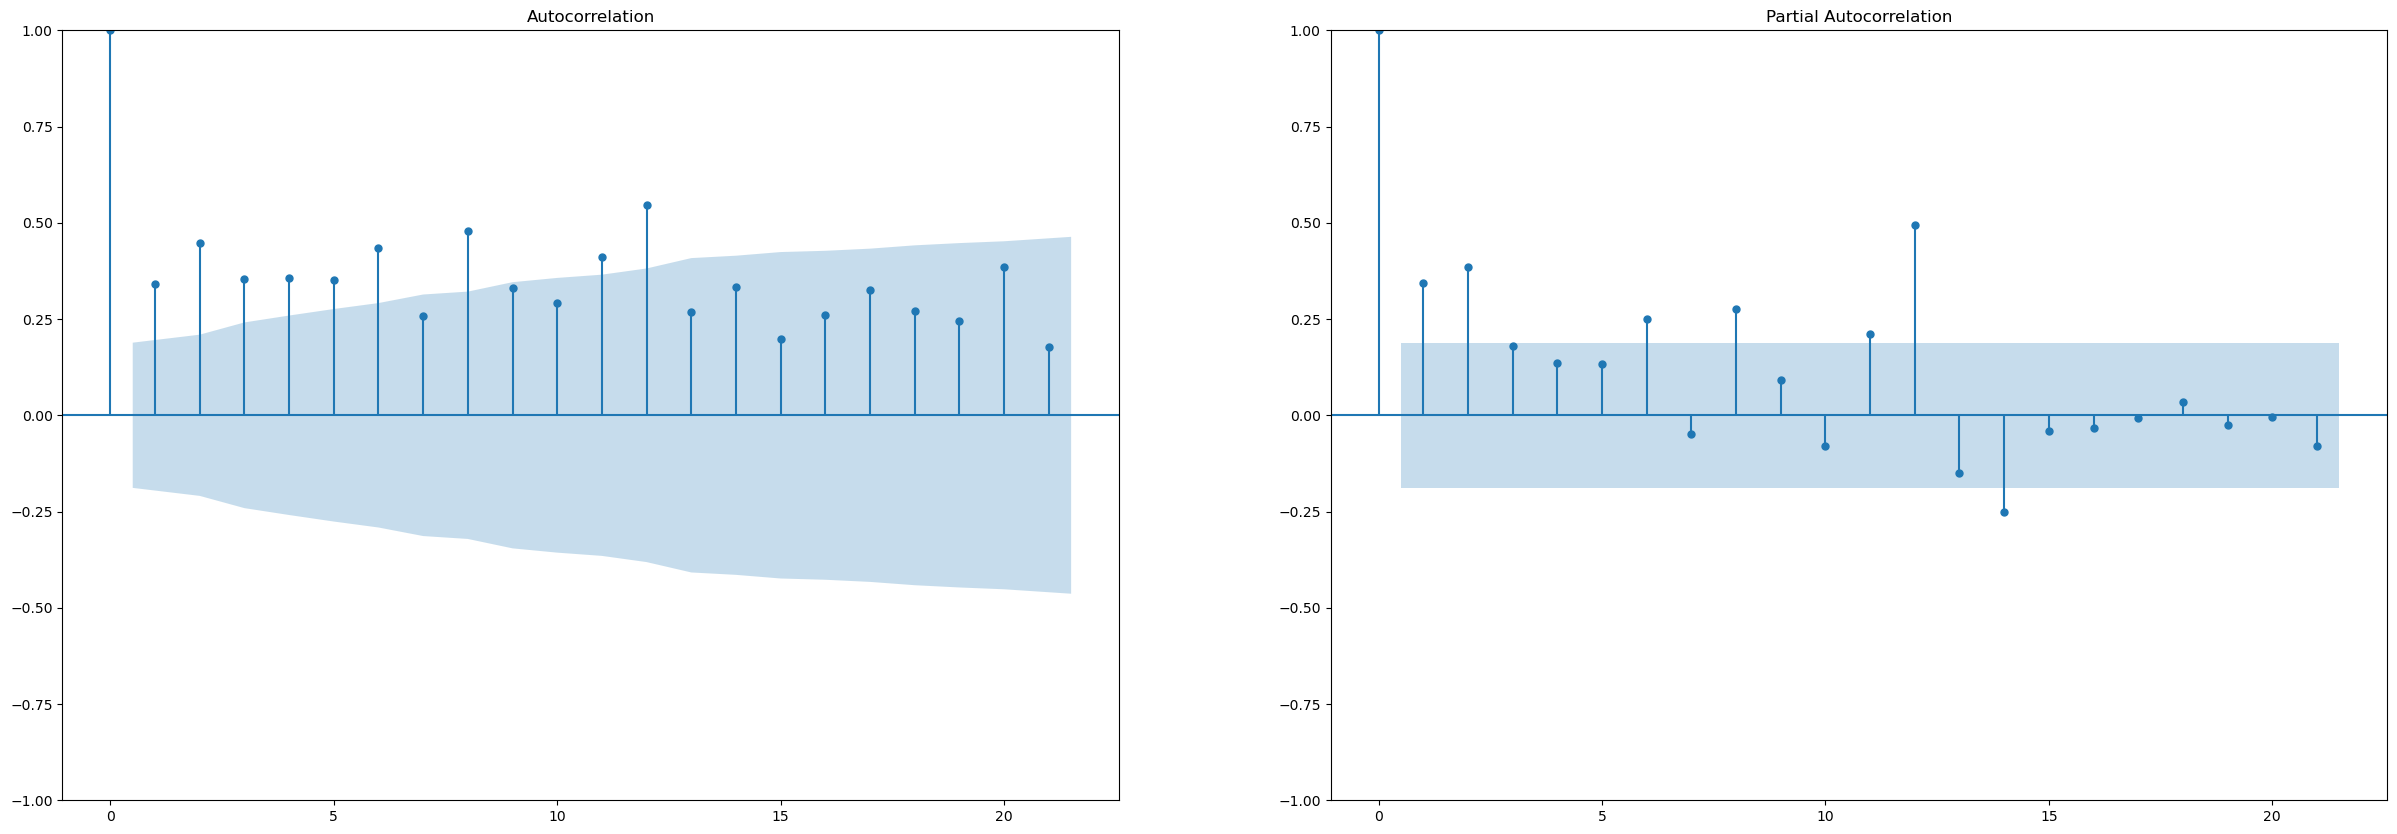

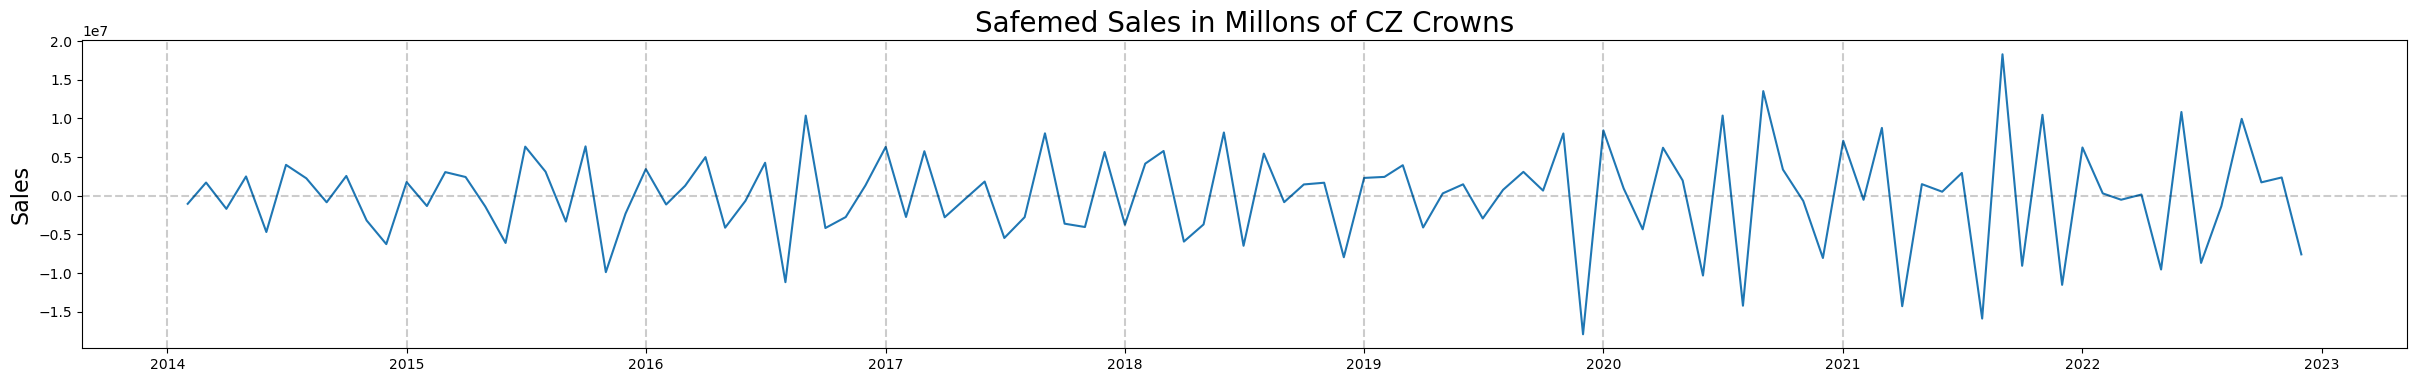

In [10]:
# Now we can check for ACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(30, 10))

plot_acf(df.Sales, ax=axes[0]);
plot_pacf(df.Sales, ax=axes[1]);

# We can see that timeseries are not stationary, so we try to take a first difference to make it stationary 
first_diff = df.diff()[1:]

plt.figure(figsize=(30,4))
plt.plot(first_diff)
plt.title('Safemed Sales in Millons of CZ Crowns', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# Mathematical test  can be employed as well. 
# We will test for stationarity using Augmented Dickey Fuller test 
# H0: the given ts is not covariance  stationary 
# HA: the given ts is covariance stationary 
from statsmodels.tsa.stattools import adfuller
result= adfuller(df.Sales.dropna())
print('p-value of the sales without differencing:', result[1])

result= adfuller(first_diff.Sales.diff().dropna())
print('p-value of the sales with first order differencing:', result[1])

# For without differencing, we fail to reject the Null. 
# However for 1st order differenced TS we reject the Null and our data is stationary ( p_value < 5%)

## Selecting the Lag order 

### ACF & PACF

/home/dt/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'PACF partial autocorrelation')

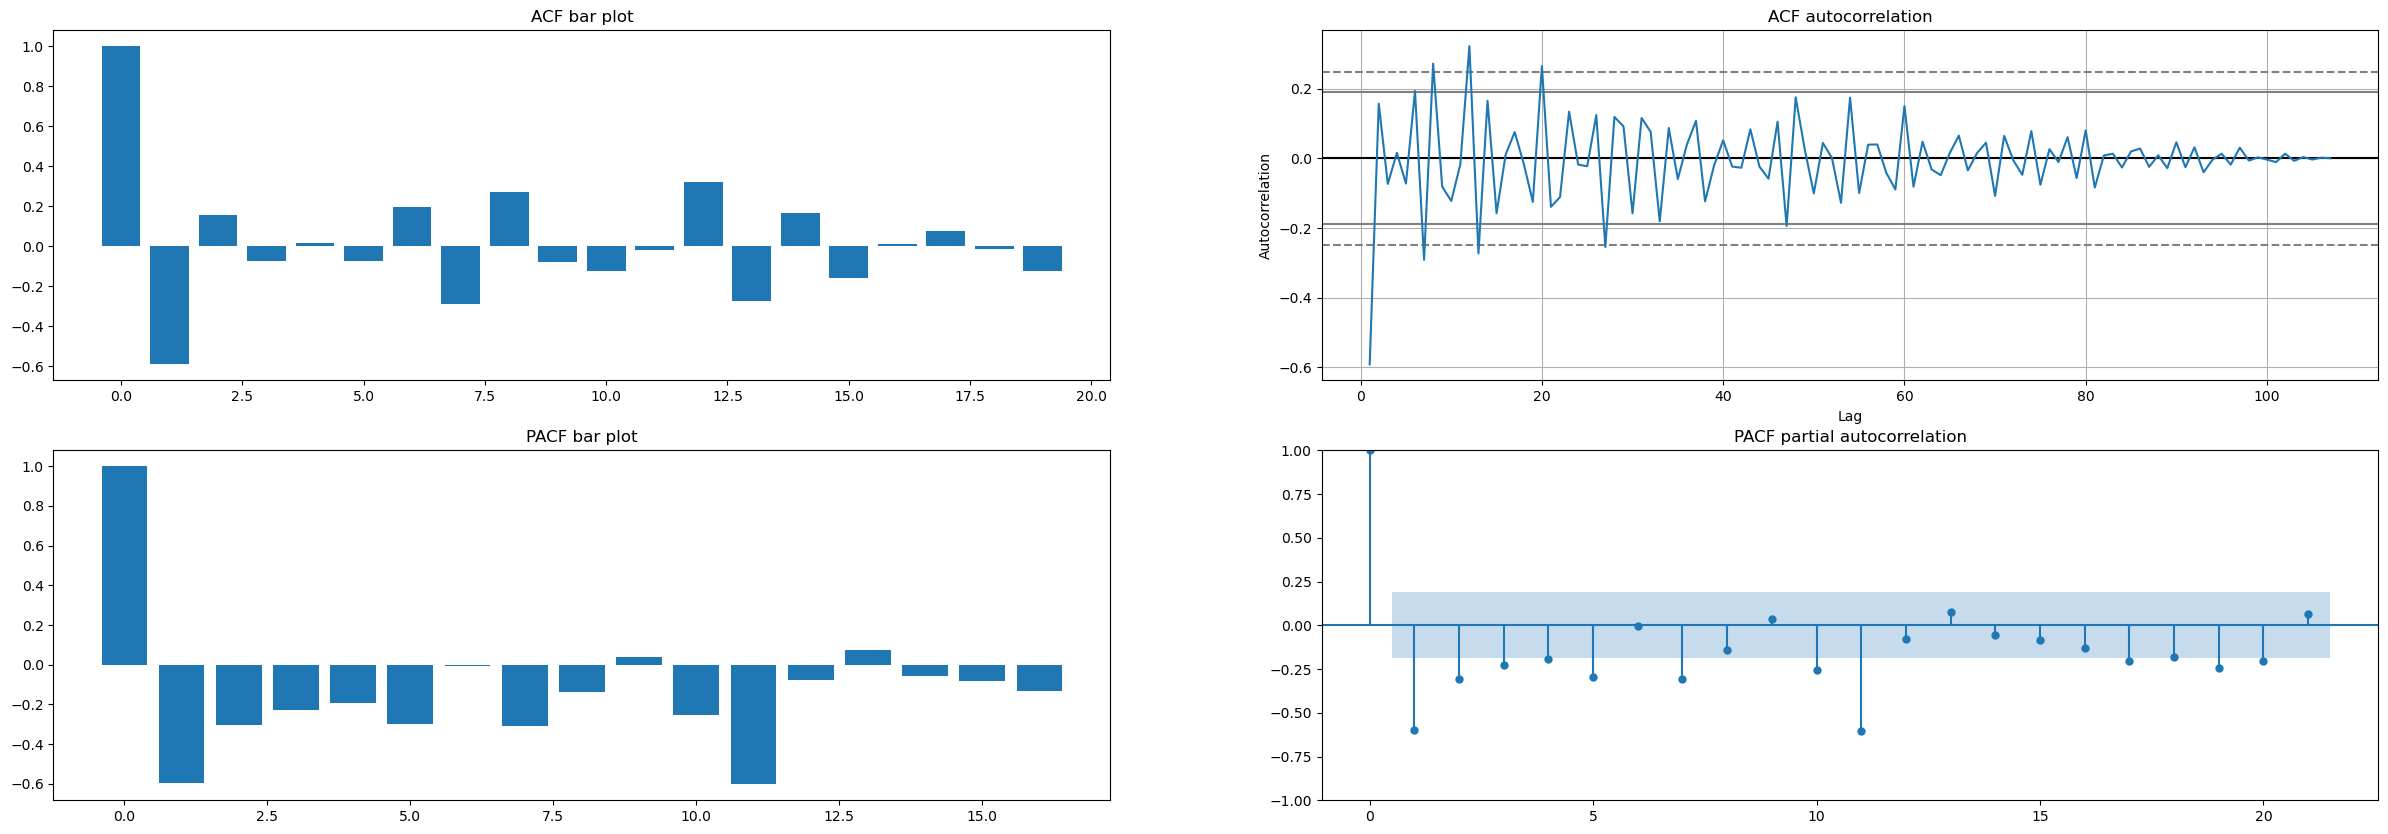

In [11]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf

fig, axes = plt.subplots(2, 2, figsize=(30, 10))

acf_vals=acf(first_diff)
num_lags= 20
axes[0, 0].bar(range (num_lags),acf_vals[:num_lags])

# Based on ACF, we should start with a seasonal MA process

autocorrelation_plot(first_diff, ax=axes[0, 1])
axes[0, 0].set_title('ACF bar plot')
axes[0, 1].set_title('ACF autocorrelation')
# It looks like for AR (p) we must choose lag order (1)

pacf_vals = pacf(first_diff)
num_lags = 17
axes[1, 0].bar(range(num_lags), pacf_vals[:num_lags])

plot_pacf(first_diff, ax=axes[1,1]);
axes[1, 0].set_title('PACF bar plot')
axes[1, 1].set_title('PACF partial autocorrelation')


* It looks like for AR (p) we must choose lag order (1)
* it looks like for MA we should choose lag order (1), (2) or (11)

In [12]:
from datetime import datetime
from datetime import timedelta
from time import time

train_end = datetime(2021,12,1)
test_end = datetime(2022,12,1)

train_df = df[:-cutoff_train_test]
test_df = df[-cutoff_train_test:]


## Fit the SARIMA Model on lags chosen based on ACF and PACF

/home/dt/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45971D+01    |proj g|=  1.82369D-01

At iterate    5    f=  1.45114D+01    |proj g|=  2.32507D-03

At iterate   10    f=  1.45113D+01    |proj g|=  1.39638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.396D-05   1.451D+01
  F =   14.511343717288334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model Fitting Time: 0.85154128074646
 

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

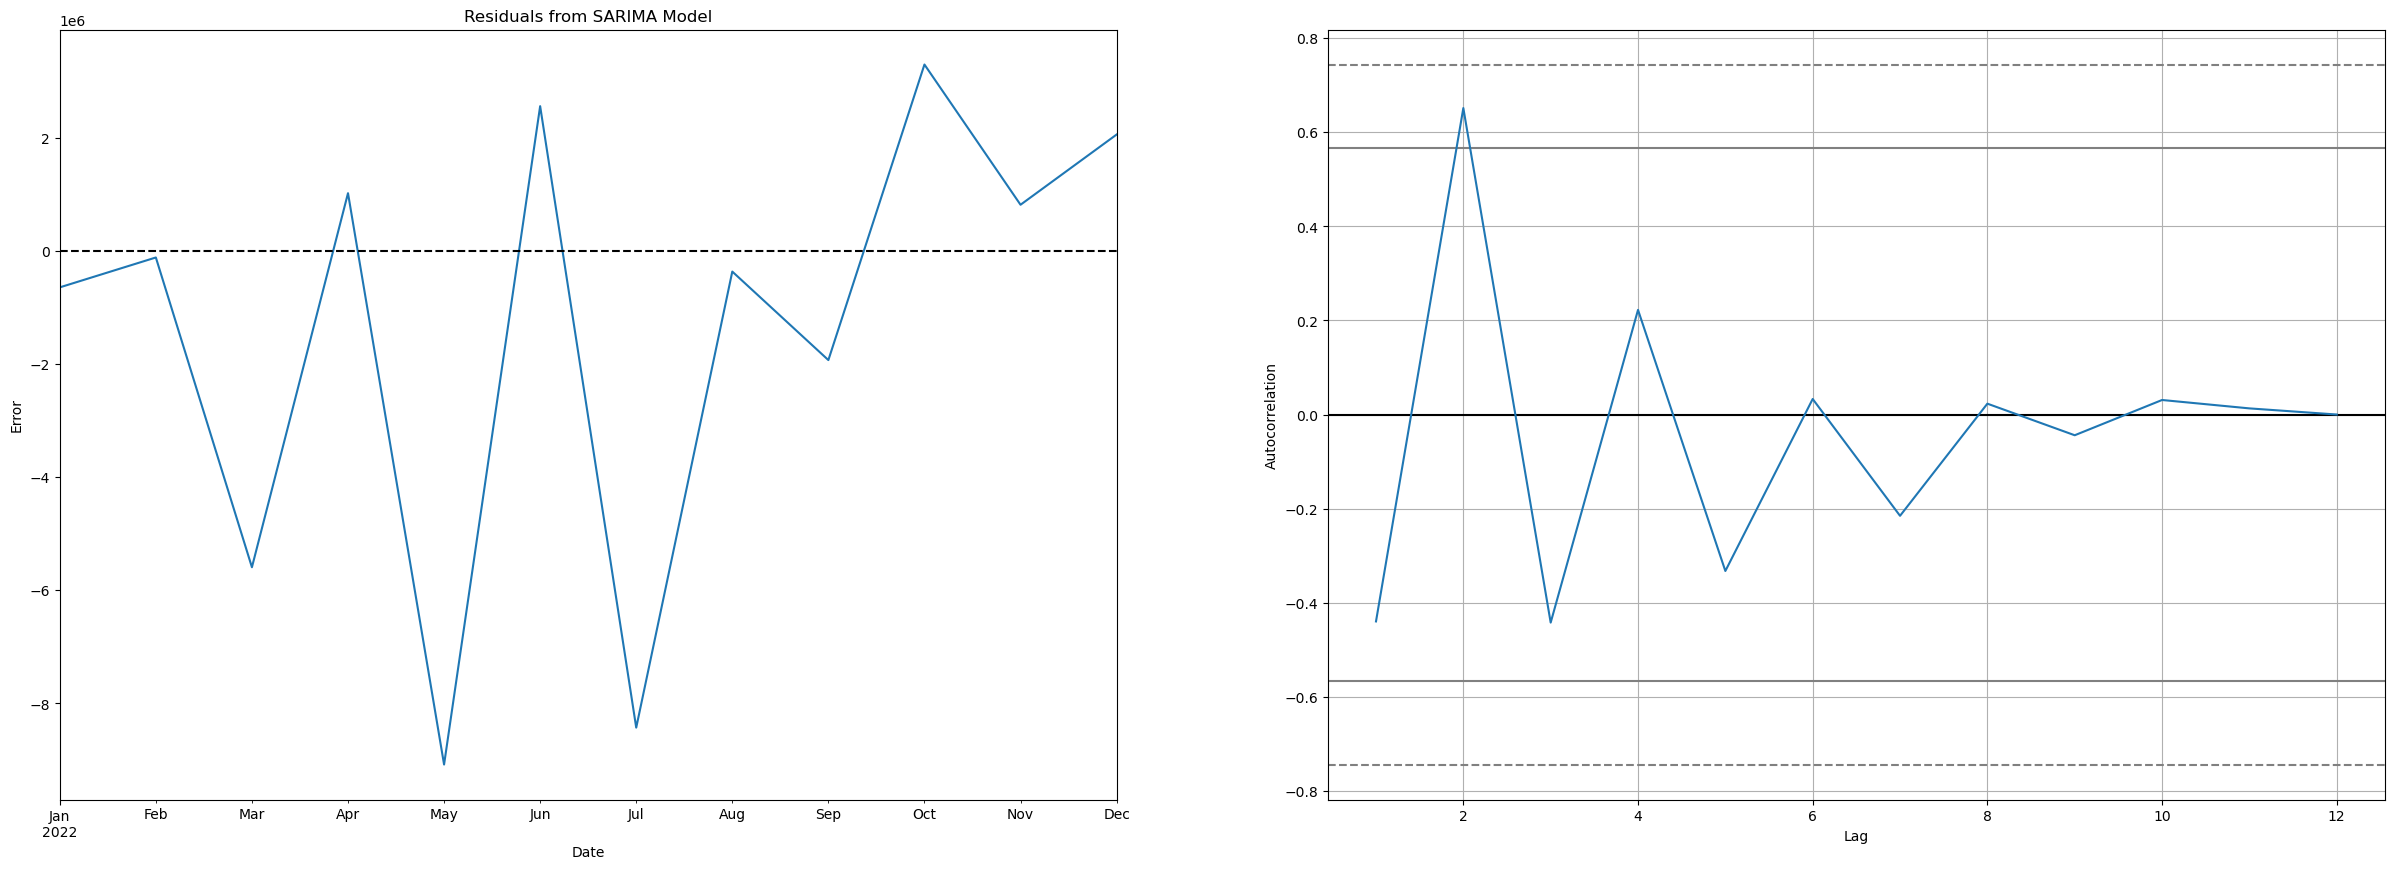

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

fig, axes = plt.subplots(1, 2, figsize=(30, 10))

my_order1 = (1,1,1)
my_seasonal_order1 =(1,1,1,12)

# define model 
model1 = SARIMAX(train_df, order= my_order1, seasonal_order= my_seasonal_order1, freq="MS")

# fit the model1 
start = time()
model_fit1 = model1.fit()
end = time()
print('Model Fitting Time:', end - start)

print(model_fit1.summary())

#get the predictions and residuals
predictions11 = model_fit1.forecast(len(test_df))
predictions1 = pd.Series(predictions11, index=test_df.index)
residuals1 = test_df['Sales'] - predictions1

residuals1.plot(ax=axes[0], title='Residuals from SARIMA Model', ylabel='Error')
axes[0].axhline(0, linestyle='--', color='k')
autocorrelation_plot(residuals1, ax=axes[1])

4208130.426976186 10.146432123593437


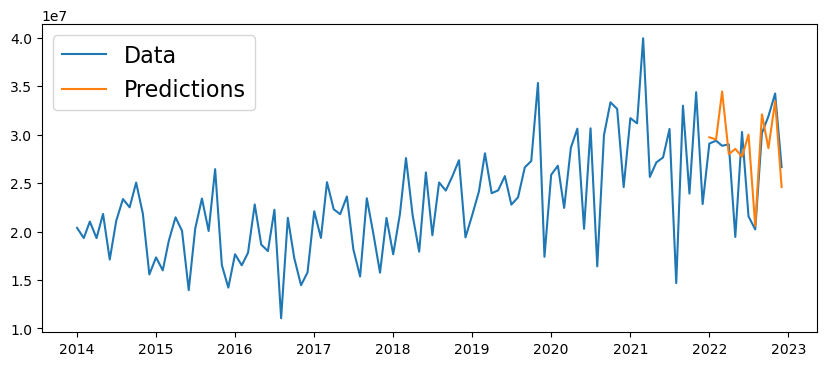

In [14]:
import math
plt.figure(figsize=(10,4))

plt.plot(df["Sales"])
plt.plot(predictions1)
plt.legend(('Data', 'Predictions'), fontsize=16)
mserr = mean_squared_error(predictions1[-cutoff_train_test:].values, df["Sales"][-cutoff_train_test:].values)
stat_error_value = math.sqrt(mserr)
stat_percent_error = mean_absolute_percentage_error(predictions1[-cutoff_train_test:].values, df["Sales"][-cutoff_train_test:].values)
print(stat_error_value, stat_percent_error)

In [ ]:
from tqdm import tqdm_notebook
from itertools import product

def optimize_SARIMA(parameters_list, d, D, s, exog):
    results = []
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

result_df = optimize_SARIMA(parameters_list, 1, 1, 12, df['Sales'])
result_df.head(10)


/home/dt/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/dt/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dt/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22131D+01    |proj g|=  1.04472D+02

At iterate    5    f=  1.53283D+01    |proj g|=  9.91088D-01

At iterate   10    f=  1.46183D+01    |proj g|=  1.64132D-01

At iterate   15    f=  1.45370D+01    |proj g|=  1.15868D-01

At iterate   20    f=  1.43878D+01    |proj g|=  4.19944D-02

At iterate   25    f=  1.43759D+01    |proj g|=  2.68299D-02

At iterate   30    f=  1.43648D+01    |proj g|=  1.00310D-02

At iterate   35    f=  1.43640D+01    |proj g|=  8.41738D-03

At iterate   40    f=  1.43623D+01    |proj g|=  1.78247D-02

At iterate   45    f=  1.43605D+01    |proj g|=  4.36160D-03

At iterate   50    f=  1.43600D+01    |proj g|=  6.18395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

/home/dt/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model Fitting Time: 12.6671621799469
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   96
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood               -1378.561
Date:                            Thu, 23 Mar 2023   AIC                           2783.122
Time:                                    20:42:03   BIC                           2814.567
Sample:                                01-01-2014   HQIC                          2795.754
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1303      0.163    -13.032      0.000      -2.451      -1.81

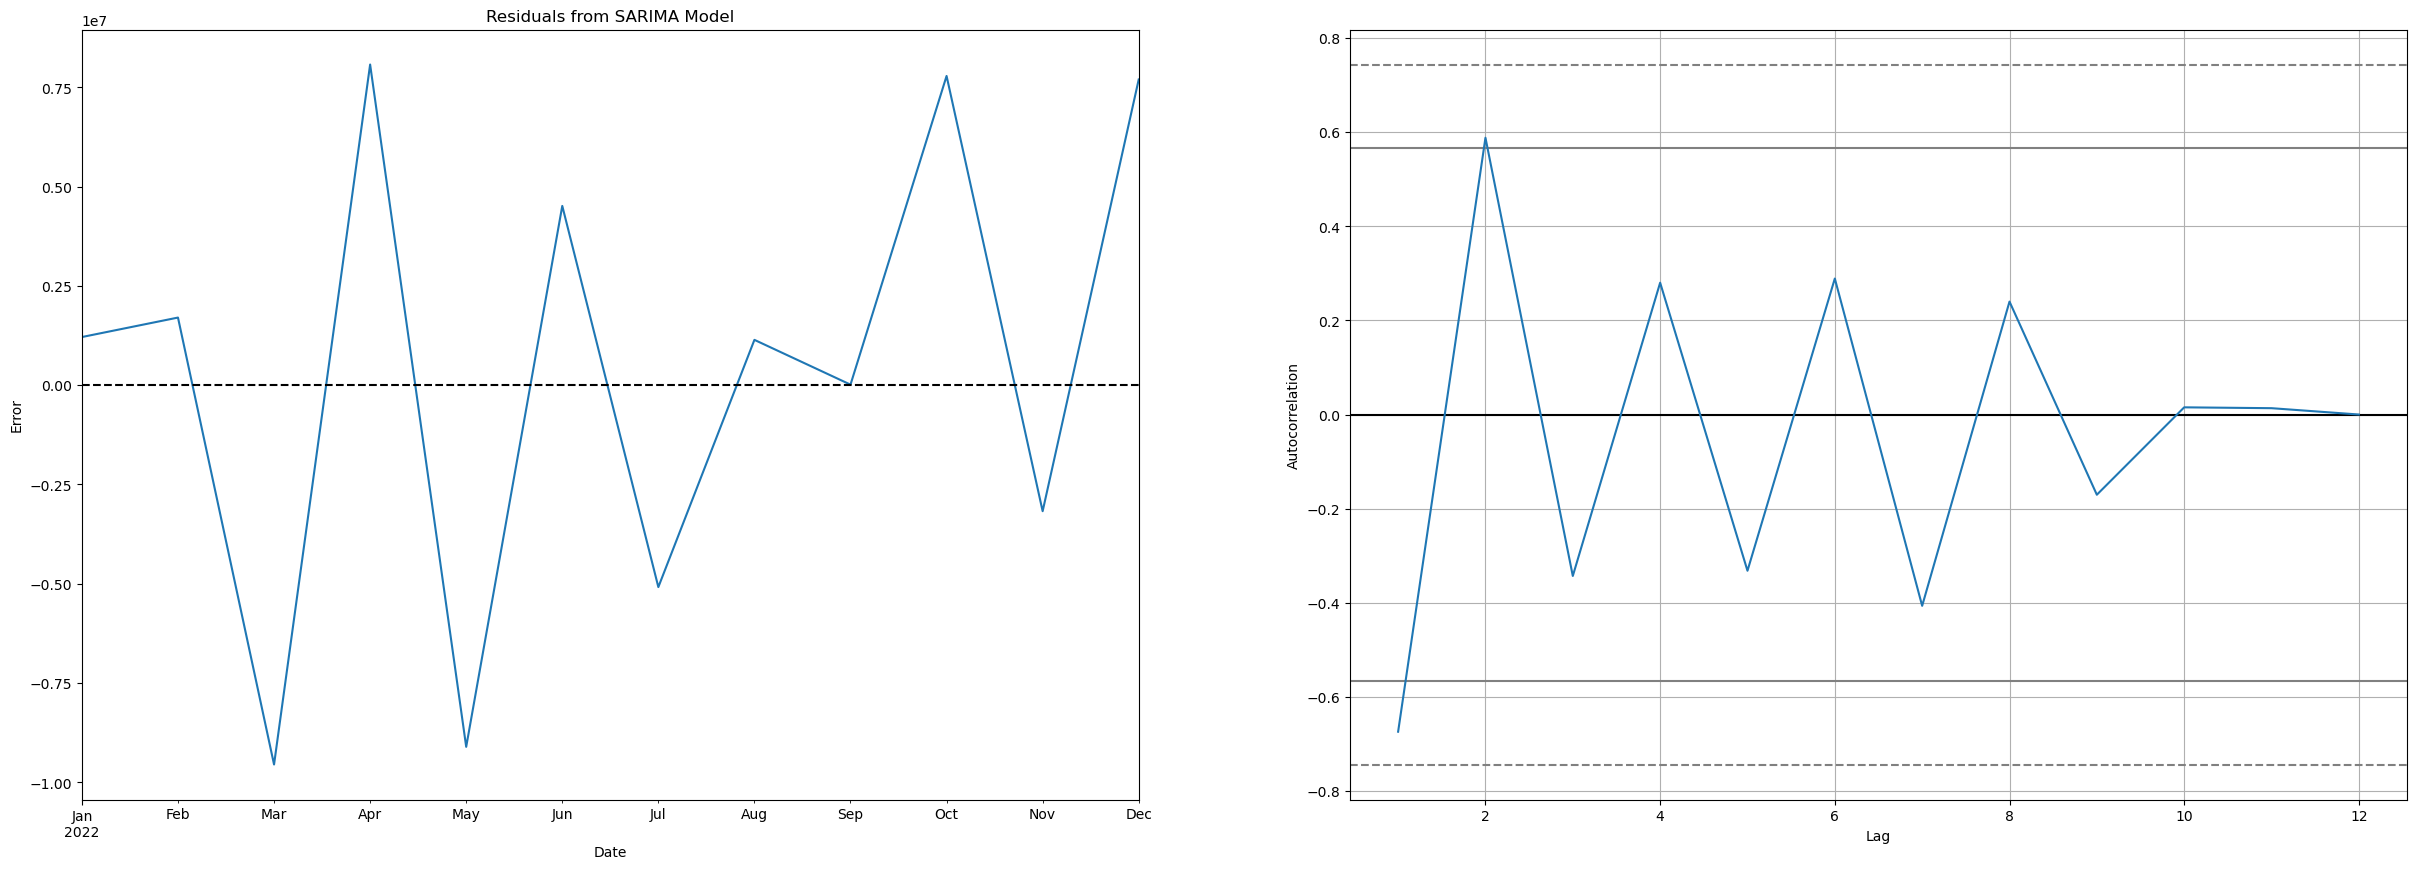

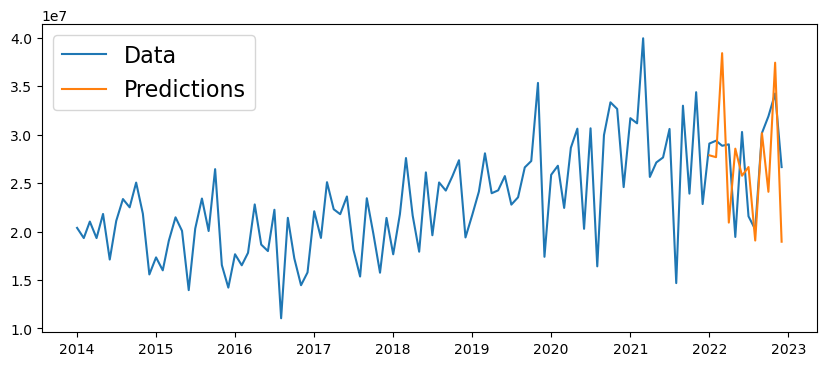

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

my_order = (3,1,3)
my_seasonal_order =(3,1,3,12)

# define model 
model = SARIMAX(train_df, order= my_order, seasonal_order= my_seasonal_order, freq="MS")
 
# fit the model 
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

# summary of the model
print(model_fit.summary())

#get the predictions and residuals
predictions = model_fit.forecast(len(test_df))
predictions = pd.Series(predictions, index=test_df.index)
residuals = test_df['Sales'] - predictions

residuals.plot(ax=axes[0], title='Residuals from SARIMA Model', ylabel='Error')
axes[0].axhline(0, linestyle='--', color='k')
autocorrelation_plot(residuals, ax=axes[1])

plt.figure(figsize=(10,4))

plt.plot(df["Sales"])
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
mserr = mean_squared_error(predictions[-cutoff_train_test:].values, df["Sales"][-cutoff_train_test:].values)
perc_err = mean_absolute_percentage_error(predictions[-cutoff_train_test:].values, df["Sales"][-cutoff_train_test:].values)
print(f"mserr={math.sqrt(mserr)} ({perc_err:.2f}%)")

## Prophet forcasting

I will use the prophet model to attempt to beat naive statistical estimates. The most naive of them is simply taking the average of the last year. Another one is taking SARIMA which adds up to the "magic" 2.755568e+07 value that appears in the code on occasion.
To configure the model, we add quaterly and monthly seasonality. Each has a periodicity which parametrizes the fourier series that the ML model uses to fit the data internally.

I add an additional seasonality "is cold" to see if winter may have an effect on sales. My prior assumption is very simple: it is cold between the months of November and February.
I guess the initial parameters from the model from the statistical analysis above:
* yearly seasonality of 6 months fits autocorrelation graph
* moderate changepoint_prior_scale to allow for some change of trend since the medical market gets permanently (non-seasonaly) disrupted

First, define helper functions. There is a lot of parameters to allow for etra regressors (later)

In [16]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import math

def is_cold(el):
    return (el.month > 10 or el.month < 3)

# add "is cold" and concatenate with another time series, if provided (for external regressors)
def prepare_time_series(df, original_df = None):
    df['is_cold'] = df['ds'].apply(is_cold)
    df['is_not_cold'] = ~df['ds'].apply(is_cold)
    if original_df is not None:
        original_df_restricted = original_df.loc[df.index.min():df.index.max(),:]
        return pd.concat([df, original_df_restricted], axis=1)
        
    return df

def create_and_fit_model(
    train_df, 
    quarterly_period=0, 
    quarterly_fourier_order=5, 
    iscold_fourier_order=1,
    fourier_order_isnotcold=2,
    changepoint_prior_scale=1., 
    yearly_seasonality=5,
    iscold_period=4,
    isnotcold_period=8,
    vaccine_period = 0,
    cpi_period = 0,
    vaccine_prior_scale = 0,
    cpi_prior_scale = 0,
    vaccine_method = 'multiplicative',
    cpi_method = 'addtive'
):
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, changepoint_prior_scale=changepoint_prior_scale, yearly_seasonality=yearly_seasonality)
    if vaccine_period > 0:
        model.add_regressor('vaccine', prior_scale=vaccine_prior_scale, mode=vaccine_method)
    if cpi_period > 0:
        model.add_regressor('CPI', prior_scale=cpi_prior_scale, mode=cpi_method)

    if quarterly_period > 0:
        model.add_seasonality(name='quarterly', period=quarterly_period, fourier_order=quarterly_fourier_order)
    if iscold_period > 0:
        model.add_seasonality(name='is_cold', period=iscold_period, fourier_order=iscold_fourier_order, prior_scale = .3, condition_name='is_cold')
    if isnotcold_period > 0:
        model.add_seasonality(name='is_not_cold', period=isnotcold_period, fourier_order=fourier_order_isnotcold, prior_scale = .3, condition_name='is_not_cold')
    model.fit(train_df)
    return model

def get_percentage_err(df_gt, df_pred, naive_pred_err):
    df_pred = df_pred[-len(df_gt):]
    error1 = mean_squared_error(df_gt[['y']].values, df_pred[['yhat']].values)
    perc_improvement = (naive_pred_err-math.sqrt(error1))/max(math.sqrt(error1),naive_pred_err)
    return perc_improvement


def print_mserr(df_gt, df_pred, naive_pred, best = None):
    df_pred = df_pred[-len(df_gt):]
    error1 = mean_squared_error(df_gt[['y']].values, df_pred[['yhat']].values)
    error2 = stat_error_value
    abs_perc_err = mean_absolute_percentage_error(df_gt[['y']].values, df_pred[['yhat']].values)

    perc_improvement = get_percentage_err(df_gt, df_pred, error2)
    if best is not None and best > math.sqrt(error1):
        print("error report:")
        print(f"Error using Prophet model: RMSE={math.sqrt(error1)}, MAE={abs_perc_err}%")
        print(f"RMSE using Naive prediction (SARIMA) model: {error2}")
        print(f"RMSE improved by {perc_improvement*100:.2f}%")
    return math.sqrt(error1)

def plot_prophet_with_parameters(df_sales, plot_components=False, **kwargs):
    print("Running with configuration:", kwargs)
    df = df_sales.reset_index()

    df=df.rename(columns={'Date':'ds', 'Sales':'y'})
    df = prepare_time_series(df)
    train_df = df[:-cutoff_train_test]
    test_df = df[-cutoff_train_test:]

    model = create_and_fit_model(train_df, **kwargs)

    future = model.make_future_dataframe(periods=cutoff_train_test, freq = 'm')
    future = prepare_time_series(future)
    forecast = model.predict(future)

    fig, axes = plt.subplots(1, 2, figsize=(30, 10))

    fig = model.plot(forecast, ax=axes[0])
    if plot_components:
        model.plot_components(forecast)
    add_changepoints_to_plot(axes[0], model, forecast)

    train_df.set_index('ds', inplace=True)
    forecast.set_index('ds', inplace=True)

    viz_df = train_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

    viz_df[['yhat']].plot(ax=axes[1])
    df_sales[['Sales']].plot(ax=axes[1])

    print_mserr(test_df, forecast, stat_error_value, 1e99)


Make a pure timeseries prediction with no external factors (except "is cold")

20:42:16 - cmdstanpy - INFO - Chain [1] start processing


Running with configuration: {}


20:42:17 - cmdstanpy - INFO - Chain [1] done processing


error report:
Error using Prophet model: RMSE=3936466.05005507, MAE=11.159740199128292%
RMSE using Naive prediction (SARIMA) model: 4208130.426976186
RMSE improved by 6.46%


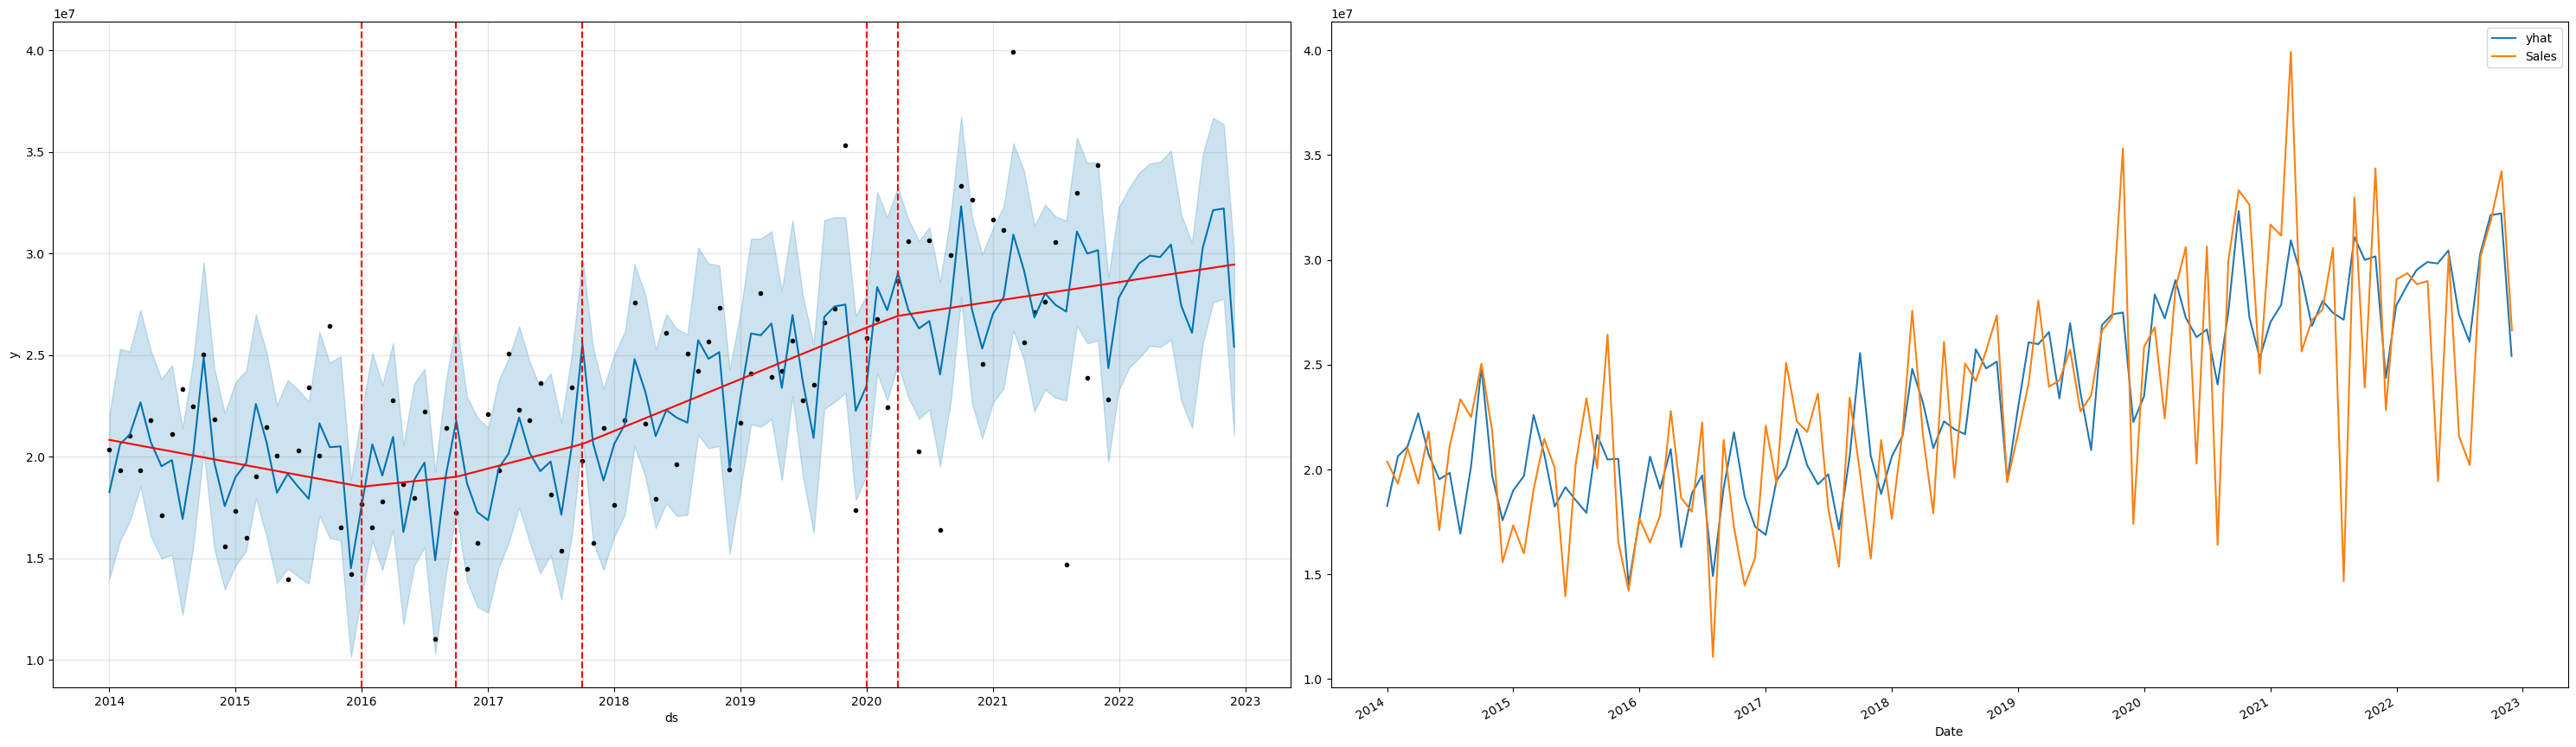

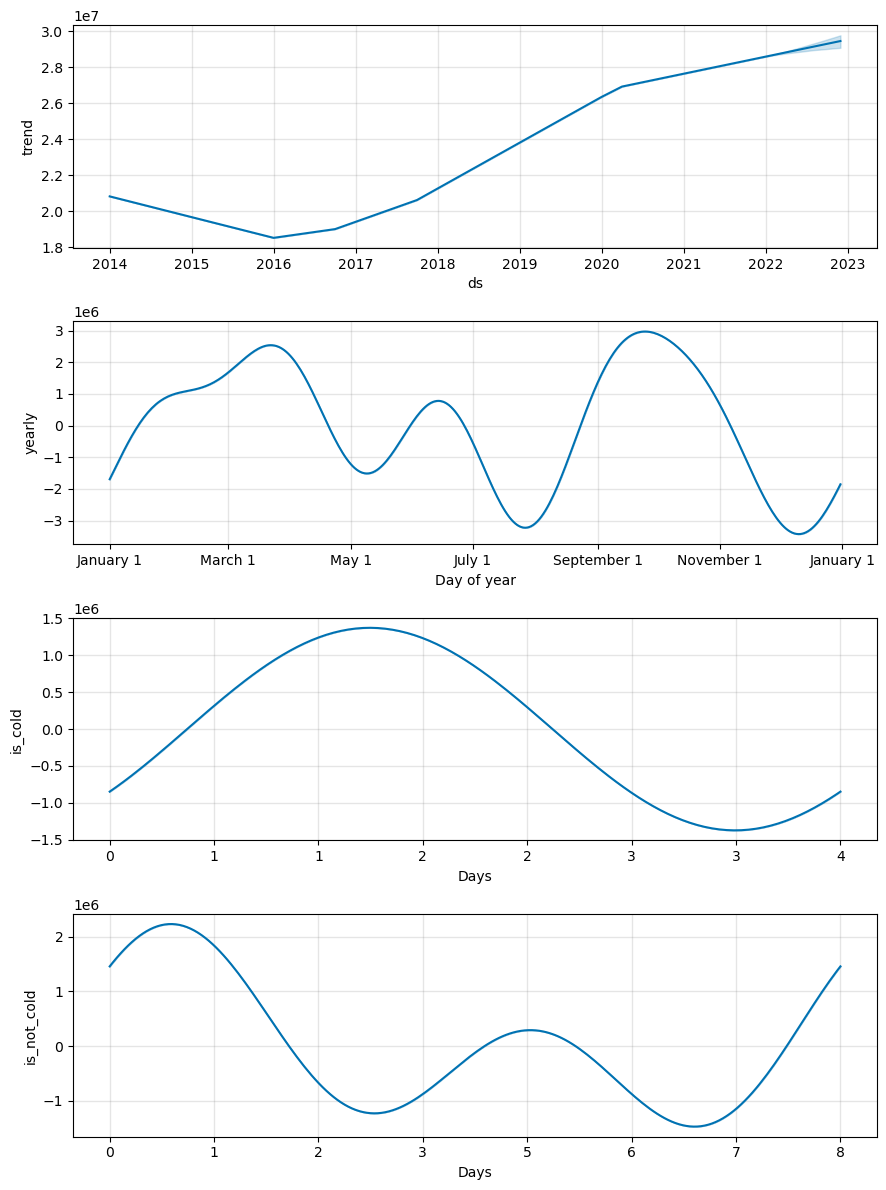

In [17]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import math

df_sales = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')
plot_prophet_with_parameters(df_sales, plot_components=True)

## Mini-Conclusion

* Prophet outperforms naive statistical models: 6% improvement
* Prophet catches the trend and trend changes
* Prophet catches the seasonality around the changes


## Search for hyperparameters on grid

Let's try to optimize hyperparameters to see how far we can push prediction on this time series without resorting to external regressors

In [18]:
df_sales = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')
df = df_sales.reset_index()

df=df.rename(columns={'Date':'ds', 'Sales':'y'})
df = prepare_time_series(df)
train_df = df[:-cutoff_train_test]
test_df = df[-cutoff_train_test:]
model = create_and_fit_model(train_df)
future = model.make_future_dataframe(periods=cutoff_train_test, freq = 'm')
future = prepare_time_series(future)



20:42:18 - cmdstanpy - INFO - Chain [1] start processing
20:42:19 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
params_grid = {
    'changepoint_prior_scale': [1,2,2.5,3], 
    'fourier_order_isnotcold': [1], 
    'iscold_fourier_order': [1], 
    'iscold_period': [0], 
    'isnotcold_period': [0], 
    'quarterly_fourier_order': [1,2,3,5], 
    'quarterly_period': [1,2,3,4,0], 
    'yearly_seasonality': [2,4,5,6,4,5,7,8,9]} 

grid = ParameterGrid(params_grid)
best_grid=None
best_score = 1e99
nb_grid = len(grid)
iteration = 0
skipped_iter=0
print(f"Running on {nb_grid} parameter combinations")
for p in grid:
    # No need to cycle through fourier orders more than once
    # when the quarterly period is disabled
    if p['quarterly_period'] == 0 and p['quarterly_fourier_order'] > 1:
        iteration+=1
        skipped_iter+=1
        continue
    if p['iscold_period'] == 0 and p['iscold_fourier_order'] > 1:
        iteration+=1
        skipped_iter+=1
        continue
    if p['isnotcold_period'] == 0 and p['fourier_order_isnotcold'] > 1:
        iteration+=1
        skipped_iter+=1
        continue
    model = create_and_fit_model(train_df,**p)
    forecast = model.predict(future)

    score = print_mserr(test_df, forecast, train_df[-cutoff_train_test:]['y'].mean(), best_score)

    if (score < best_score):
        print(f"[{iteration}/{nb_grid} ({skipped_iter} skipped)]New best grid! {p} scoring {score}")
        best_score = score
        best_grid = p
    iteration+=1


Found 2 interesting configurations:
* `{'changepoint_prior_scale': 7, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 3, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 2, 'quarterly_period': 1, 'yearly_seasonality': 5}` scoring 3290918.8791549434 (28.60% better than naive mean prediction)
However, this creates very short-term trends, lowering confidence in longer term predictions (>1 month) since the model keeps the same trend after the end of the training data.
* `{'changepoint_prior_scale': 2.5, 'fourier_order_isnotcold': 3, 'iscold_fourier_order': 2, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 1, 'quarterly_period': 1, 'yearly_seasonality': 5}` scoring 3408321.2055835156 (26.06% better than naive mean prediction)
This configuration is arguably better because it detects longer, more sustainable trends around which seasonality appears even if the score is a little bit less on this particular test set. For longer-term prediction, this configuration is preferred.


20:42:43 - cmdstanpy - INFO - Chain [1] start processing


Running with configuration: {'changepoint_prior_scale': 7, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 3, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 2, 'quarterly_period': 1, 'yearly_seasonality': 5}


20:42:43 - cmdstanpy - INFO - Chain [1] done processing
20:42:43 - cmdstanpy - INFO - Chain [1] start processing


error report:
Error using Prophet model: RMSE=3300468.1178417844, MAE=11.03056739887191%
RMSE using Naive prediction (SARIMA) model: 4208130.426976186
RMSE improved by 21.57%
Running with configuration: {'changepoint_prior_scale': 2.5, 'fourier_order_isnotcold': 3, 'iscold_fourier_order': 2, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 1, 'quarterly_period': 1, 'yearly_seasonality': 5}


20:42:44 - cmdstanpy - INFO - Chain [1] done processing
20:42:44 - cmdstanpy - INFO - Chain [1] start processing


error report:
Error using Prophet model: RMSE=3417043.511239378, MAE=11.006386666568536%
RMSE using Naive prediction (SARIMA) model: 4208130.426976186
RMSE improved by 18.80%
Running with configuration: {}


20:42:45 - cmdstanpy - INFO - Chain [1] done processing


error report:
Error using Prophet model: RMSE=3936466.05005507, MAE=11.159740199128292%
RMSE using Naive prediction (SARIMA) model: 4208130.426976186
RMSE improved by 6.46%


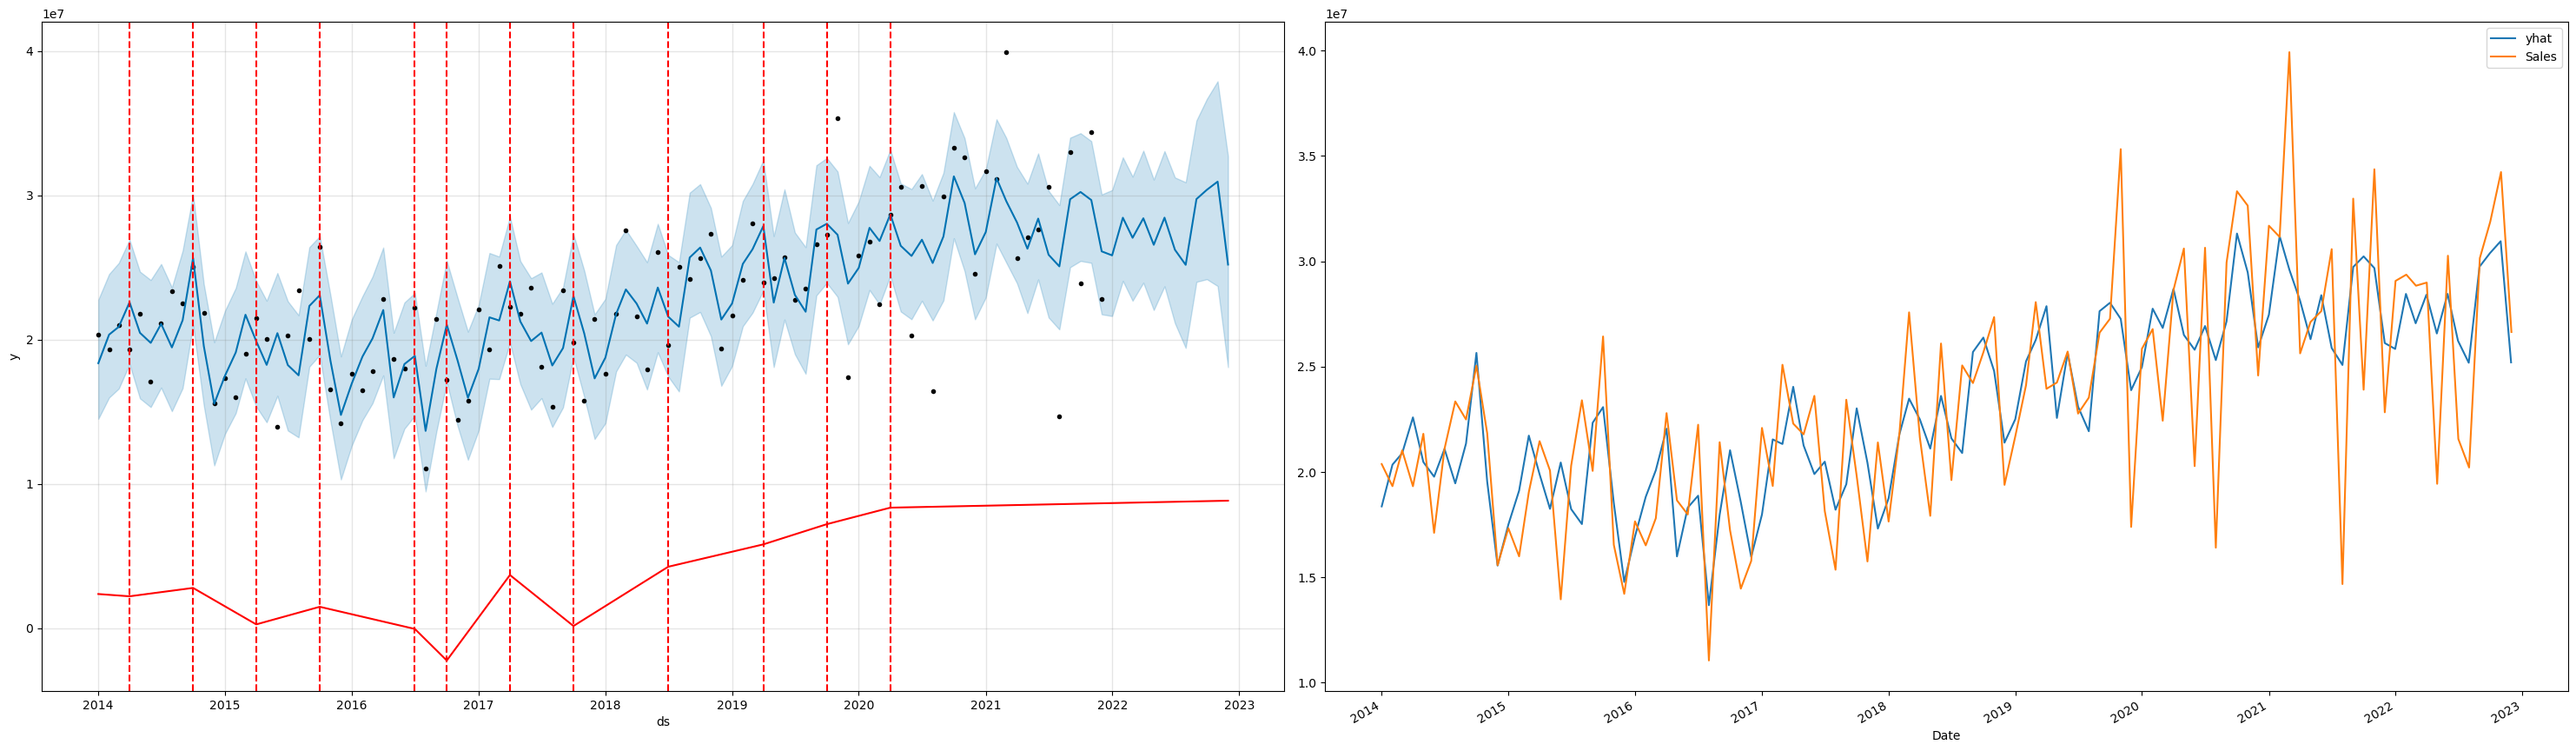

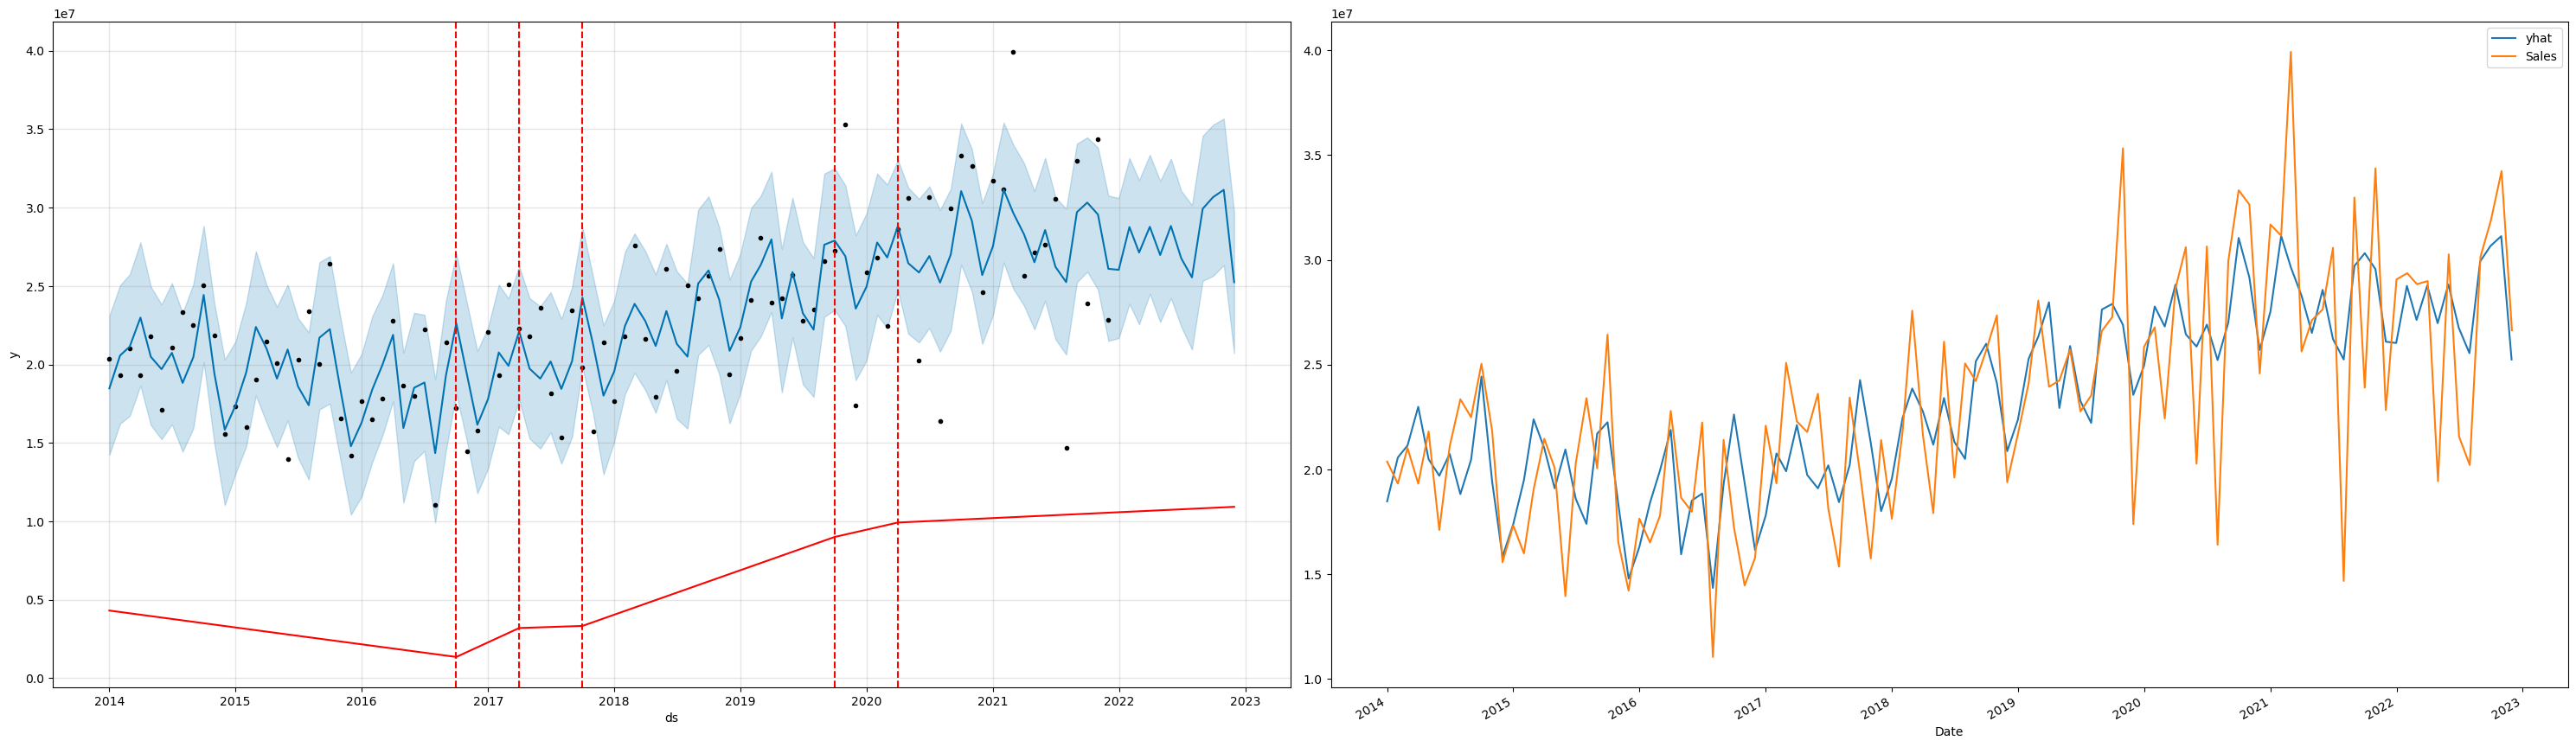

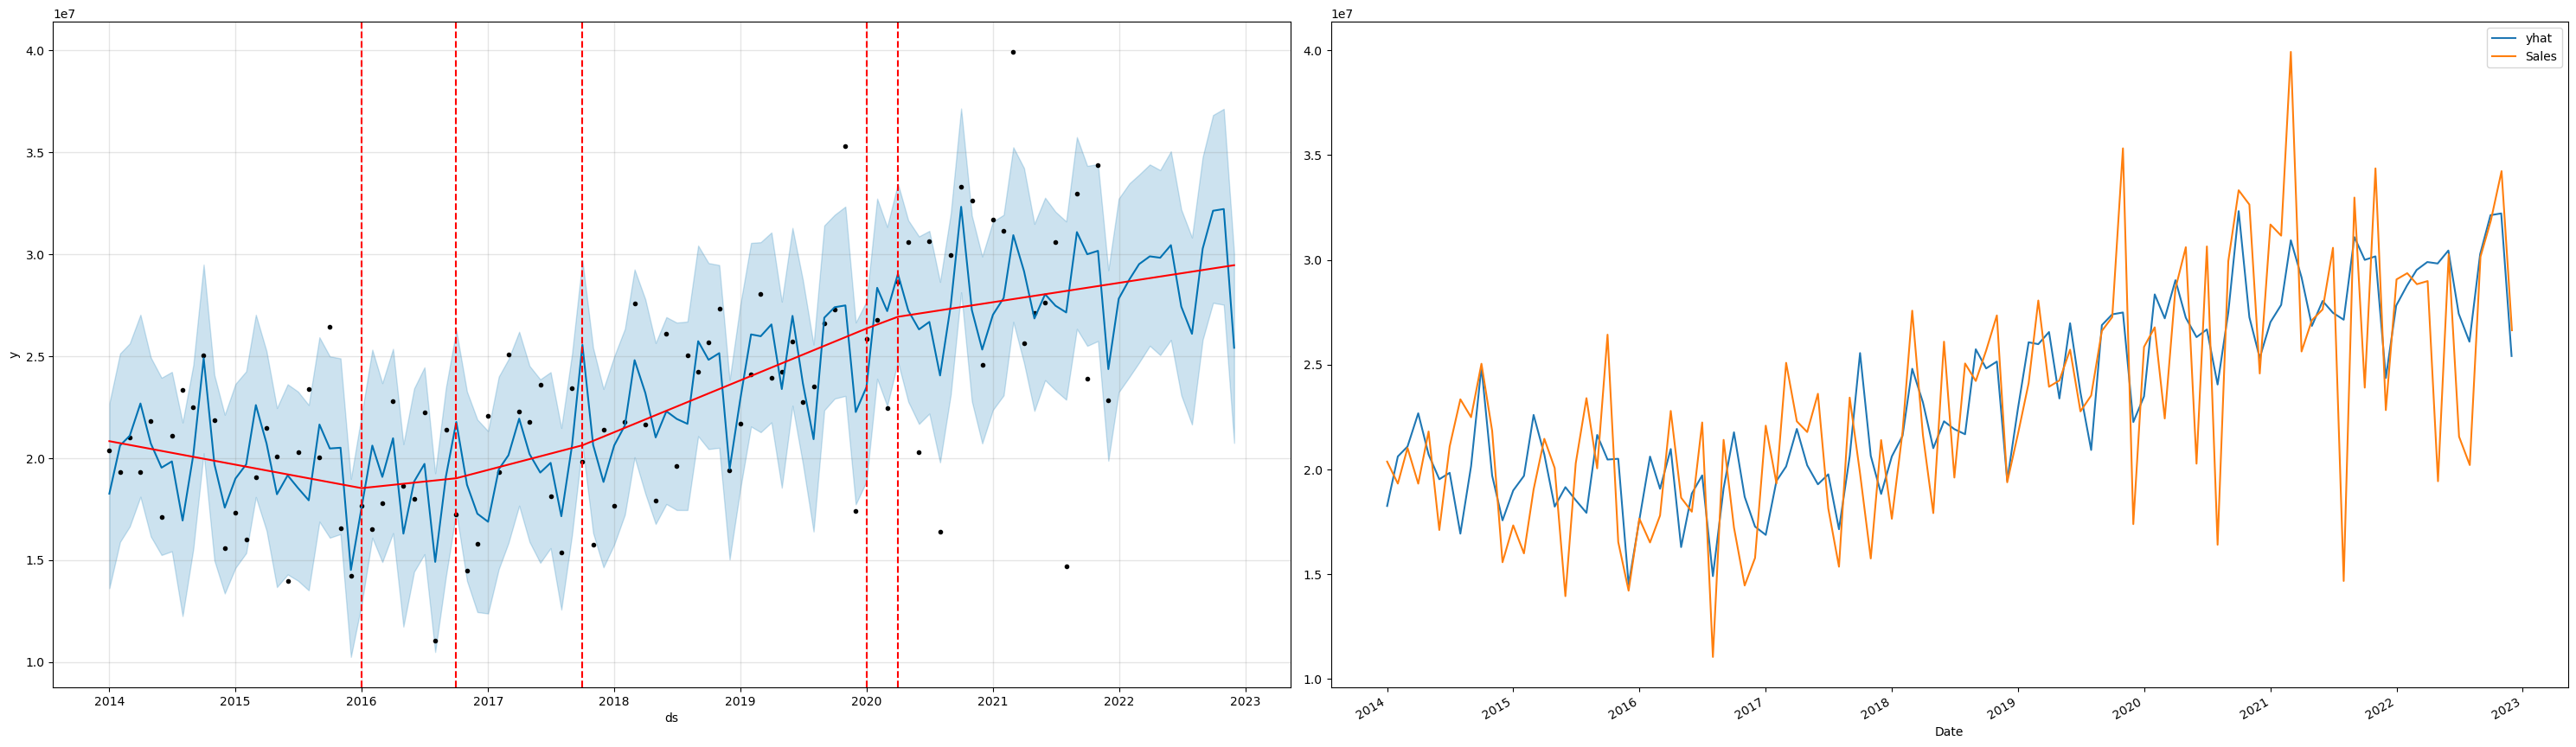

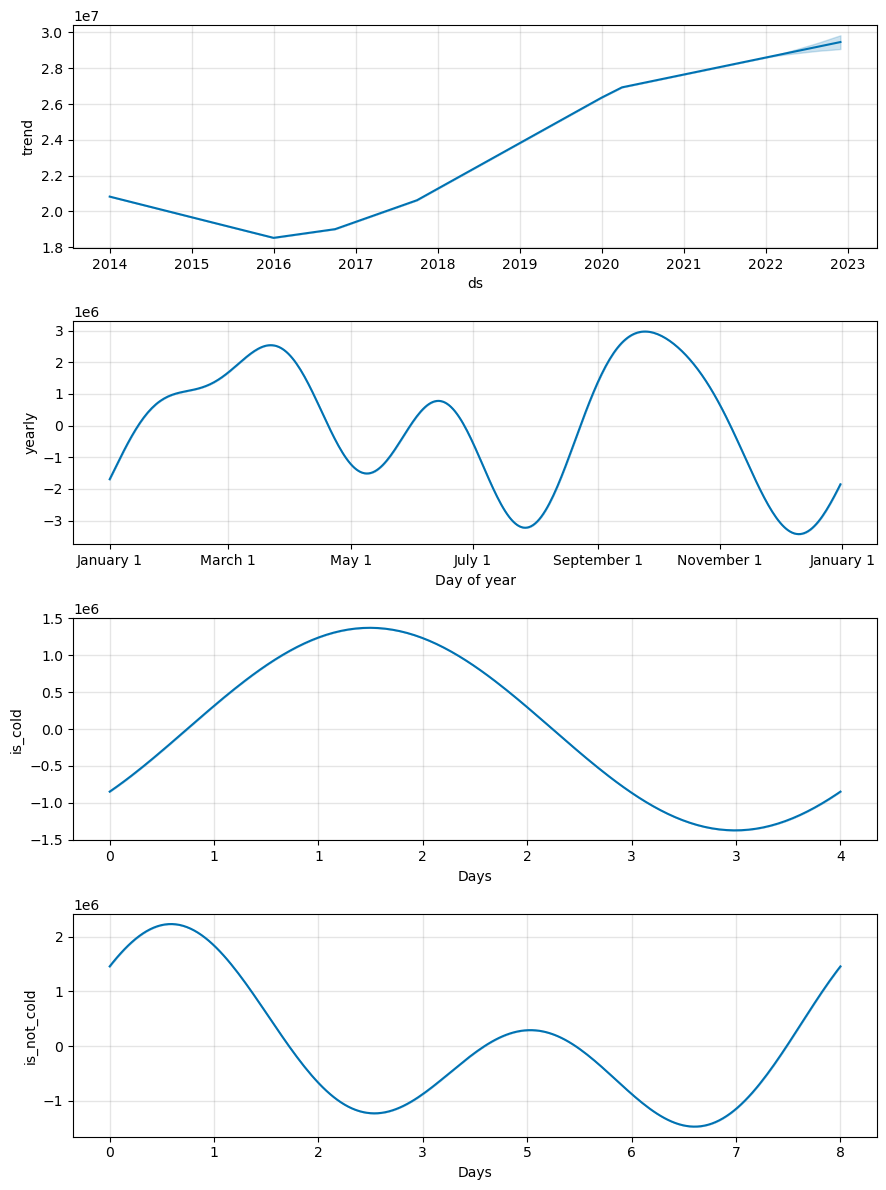

In [20]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import math

df_sales = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')

plot_prophet_with_parameters(df_sales, **{'changepoint_prior_scale': 7, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 3, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 2, 'quarterly_period': 1, 'yearly_seasonality': 5})
plot_prophet_with_parameters(df_sales, **{'changepoint_prior_scale': 2.5, 'fourier_order_isnotcold': 3, 'iscold_fourier_order': 2, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 1, 'quarterly_period': 1, 'yearly_seasonality': 5})
plot_prophet_with_parameters(df_sales, plot_components=True)


## Add external regressors

As we have seen in the other notebook, covid vaccination rates in Germany correlate with sales data. It is therefore possible that there is a link, however complex between general vaccine rates and sales. But general vaccine rates are hard to find, everything is just about covid. So I took data from google trends and verified that it does correlate with actual vaccine data (to do: formally verify the correlation). It is also worth adding CPI data even if we disable it at first

### Adding Vaccine Data

The first thing I do is check if there is some correlation between vaccine rates and sales. I don't expect this correlation to be too high because vaccines are a specific medical procedure but I expect some correlaton because vaccines are also very common. The biggest chance I have to see a link is during COVID where sales of vaccines would defines sales for many medical companies. So I found the [german COVID vaccine rates datasets](https://impfdashboard.de/en) and correlated it with sales. If I find a correlation then I can take general vaccine data and hope to use it as a regressor. Even if the influance is more complex there, the fact that there is a link in the most obvious COVID case indicates that vaccines may be a useful feature.

In [21]:
from sklearn import preprocessing

df_covid = pd.read_table("covid_official_vaccine_rates.csv", parse_dates=True)

df_covid['date'] = pd.to_datetime(df_covid['date'])
df_covid.set_index('date', inplace=True)
df_covid = df_covid.groupby(pd.Grouper(freq='MS')).mean()
df_sales_restricted = df_sales.loc[df_covid.index.min():df_covid.index.max(),:]

min_max_scaler = preprocessing.MinMaxScaler()
sales_values_scaled = min_max_scaler.fit_transform(df_sales_restricted['Sales'].values.reshape(-1, 1))
covid_values_scaled = min_max_scaler.fit_transform(df_covid['impfungen'].values.reshape(-1, 1))
df_sales_restricted['sales_scaled'] = sales_values_scaled
df_covid['covid_scaled'] = covid_values_scaled

# Is there correlation between covid vaccines and sales?
max_correlation = max([df_covid['covid_scaled'].corr(df_sales_restricted['sales_scaled'].shift(lag)) for lag in range(-5,5)])
print(f"Covid vaccines rates and sales are correlated with a coefficient of {max_correlation:.2f}")


Covid vaccines rates and sales are correlated with a coefficient of 0.35


/tmp/ipykernel_5960/577143098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales_restricted['sales_scaled'] = sales_values_scaled


Since there is a 35% correlation it's worth trying adding vaccine rates as a feature. Of course, we don't want to add covid vaccine rates, that's too specific, more like something more generic: all vaccination rates.
Unfortunately, I have been unable to find that data, all datasets I am finding are just about COVID.
So I decided to use google trends. There, I can get a time series of any keyword searches for any period of time. Data-wise, this is exactly what I want, but is it relevant?
Let's check the relationship between the data we have (covid vaccine rates) and the same data from google trends. If we find a correlation, then we can use vaccine search trends as an external regressor.

Covid vaccines rates and google trends for COVID vaccines are correlated with a coefficient of 0.90


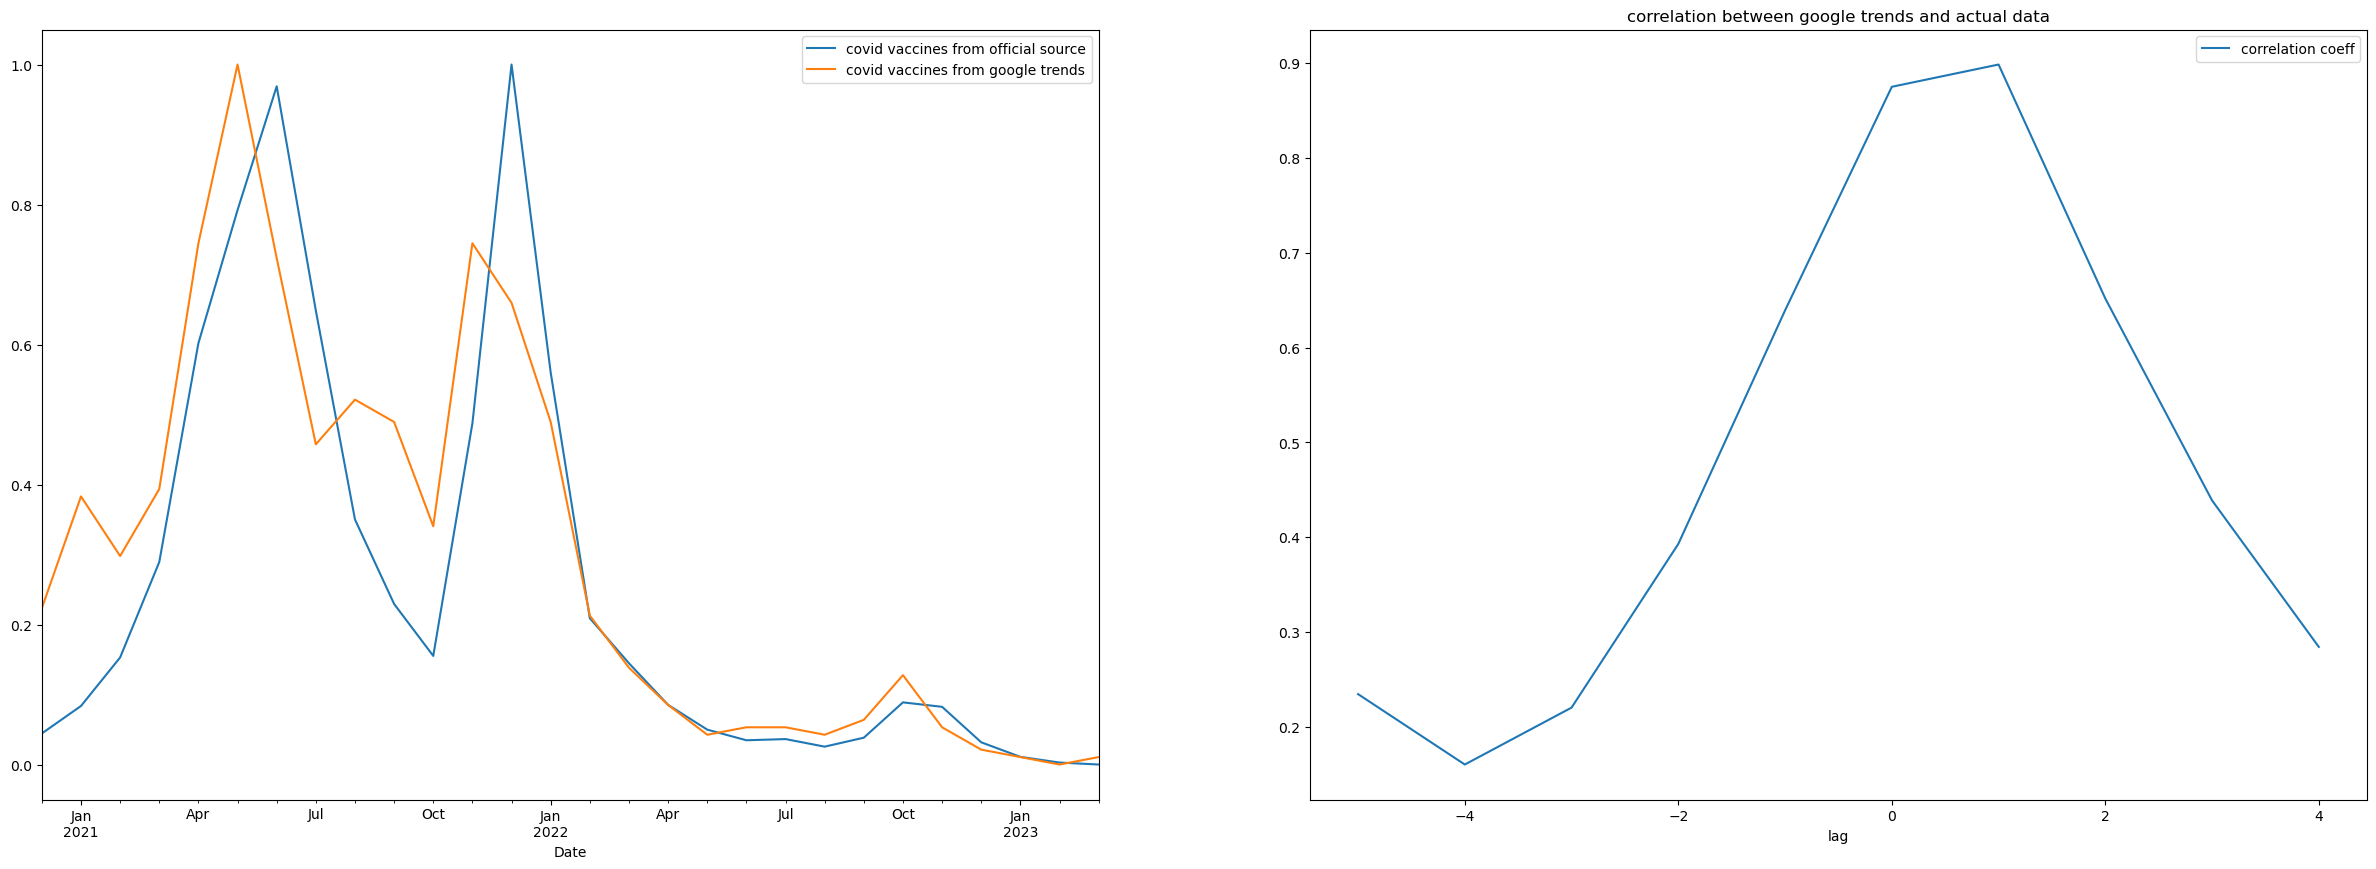

In [22]:
df_covid_trend = pd.read_csv("covid_trends.csv", parse_dates=True)
df_covid_trend['Date'] = pd.to_datetime(df_covid_trend['Date'], format='%Y-%m')
df_covid_trend.set_index('Date', inplace=True)
df_covid_trend = df_covid_trend.loc[df_covid.index.min():df_covid.index.max(),:]

fig, ax = plt.subplots( 1, 2, figsize=(30, 10))

min_max_scaler = preprocessing.MinMaxScaler()
df_covid_trend_scaled = min_max_scaler.fit_transform(df_covid_trend['vaccine'].values.reshape(-1, 1))
df_covid_trend['covid_trend_scaled'] = df_covid_trend_scaled

df_covid['covid_scaled'].plot(ax=ax[0])
df_covid_trend['covid_trend_scaled'].plot(ax=ax[0])
ax[0].legend(["covid vaccines from official source","covid vaccines from google trends"])

croscorr = [df_covid['covid_scaled'].corr(df_covid_trend['covid_trend_scaled'].shift(lag)) for lag in range(-5,5)]
df_corr = pd.DataFrame({'lag': range(-5,5), 'corr':croscorr}).set_index('lag')
df_corr.plot(ax=ax[1], title="correlation between google trends and actual data")
ax[1].legend(["correlation coeff"])

print(f"Covid vaccines rates and google trends for COVID vaccines are correlated with a coefficient of {max(croscorr):.2f}")



Trends and actual data is very correlated for COVID vaccines and Sales and COVID Vaccine data were also correlated in 2021. Therefore, I will assume that trends and actual data would also be correlated if I would have access to vaccine rates. While there seems to be a lag of 1 month between trend and actual data for COVID (there were waiting lists), I am not making assumptions about lag for other vaccines which have been around for a long time. 

In the following, I will evaluate the data series prediction with external regressors (hyperparameters found via grid search)

20:42:47 - cmdstanpy - INFO - Chain [1] start processing


Running with configuration: {'changepoint_prior_scale': 1, 'iscold_period': 0, 'isnotcold_period': 0, 'cpi_period': 0, 'vaccine_method': 'multiplicative', 'vaccine_period': 1, 'vaccine_prior_scale': 5, 'quarterly_period': 4, 'yearly_seasonality': 5, 'quarterly_fourier_order': 5}


20:42:48 - cmdstanpy - INFO - Chain [1] done processing
20:42:48 - cmdstanpy - INFO - Chain [1] start processing


error report:
Error using Prophet model: RMSE=3308801.238538714, MAE=10.497833736048927%
RMSE using Naive prediction (SARIMA) model: 4208130.426976186
RMSE improved by 21.37%
Running with configuration: {'changepoint_prior_scale': 2, 'cpi_period': 0, 'iscold_period': 0, 'isnotcold_period': 0, 'vaccine_method': 'multiplicative', 'vaccine_period': 1, 'vaccine_prior_scale': 4, 'quarterly_period': 4, 'quarterly_fourier_order': 5, 'yearly_seasonality': 5}


20:42:49 - cmdstanpy - INFO - Chain [1] done processing
20:42:49 - cmdstanpy - INFO - Chain [1] start processing


error report:
Error using Prophet model: RMSE=3229359.4045917545, MAE=10.307243172016463%
RMSE using Naive prediction (SARIMA) model: 4208130.426976186
RMSE improved by 23.26%
Running with configuration: {'changepoint_prior_scale': 2, 'cpi_period': 0, 'fourier_order_isnotcold': 3, 'iscold_fourier_order': 2, 'iscold_period': 5, 'isnotcold_period': 4, 'vaccine_method': 'multiplicative', 'vaccine_period': 1, 'vaccine_prior_scale': 4, 'quarterly_period': 4, 'quarterly_fourier_order': 5, 'yearly_seasonality': 5}


20:42:50 - cmdstanpy - INFO - Chain [1] done processing


error report:
Error using Prophet model: RMSE=2590556.1414456205, MAE=8.8552932043489%
RMSE using Naive prediction (SARIMA) model: 4208130.426976186
RMSE improved by 38.44%


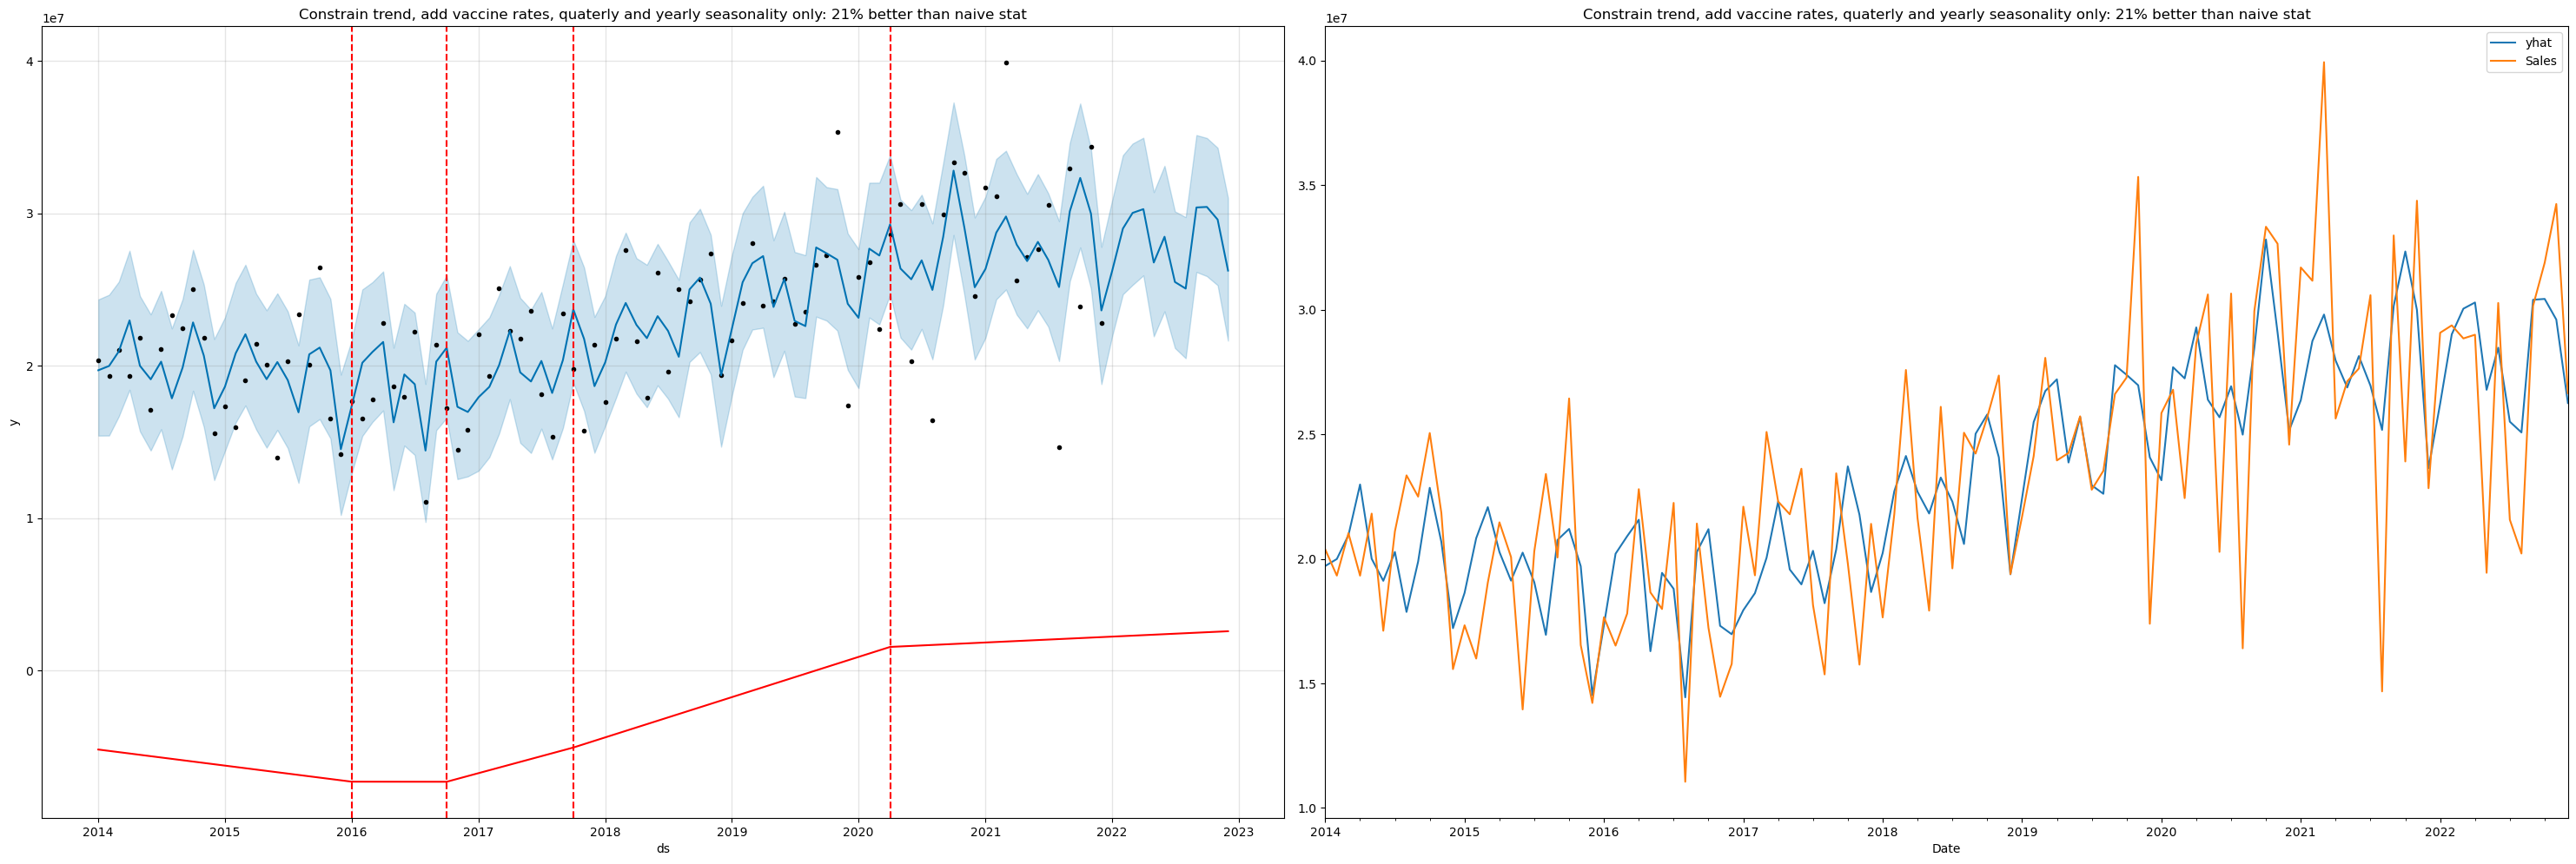

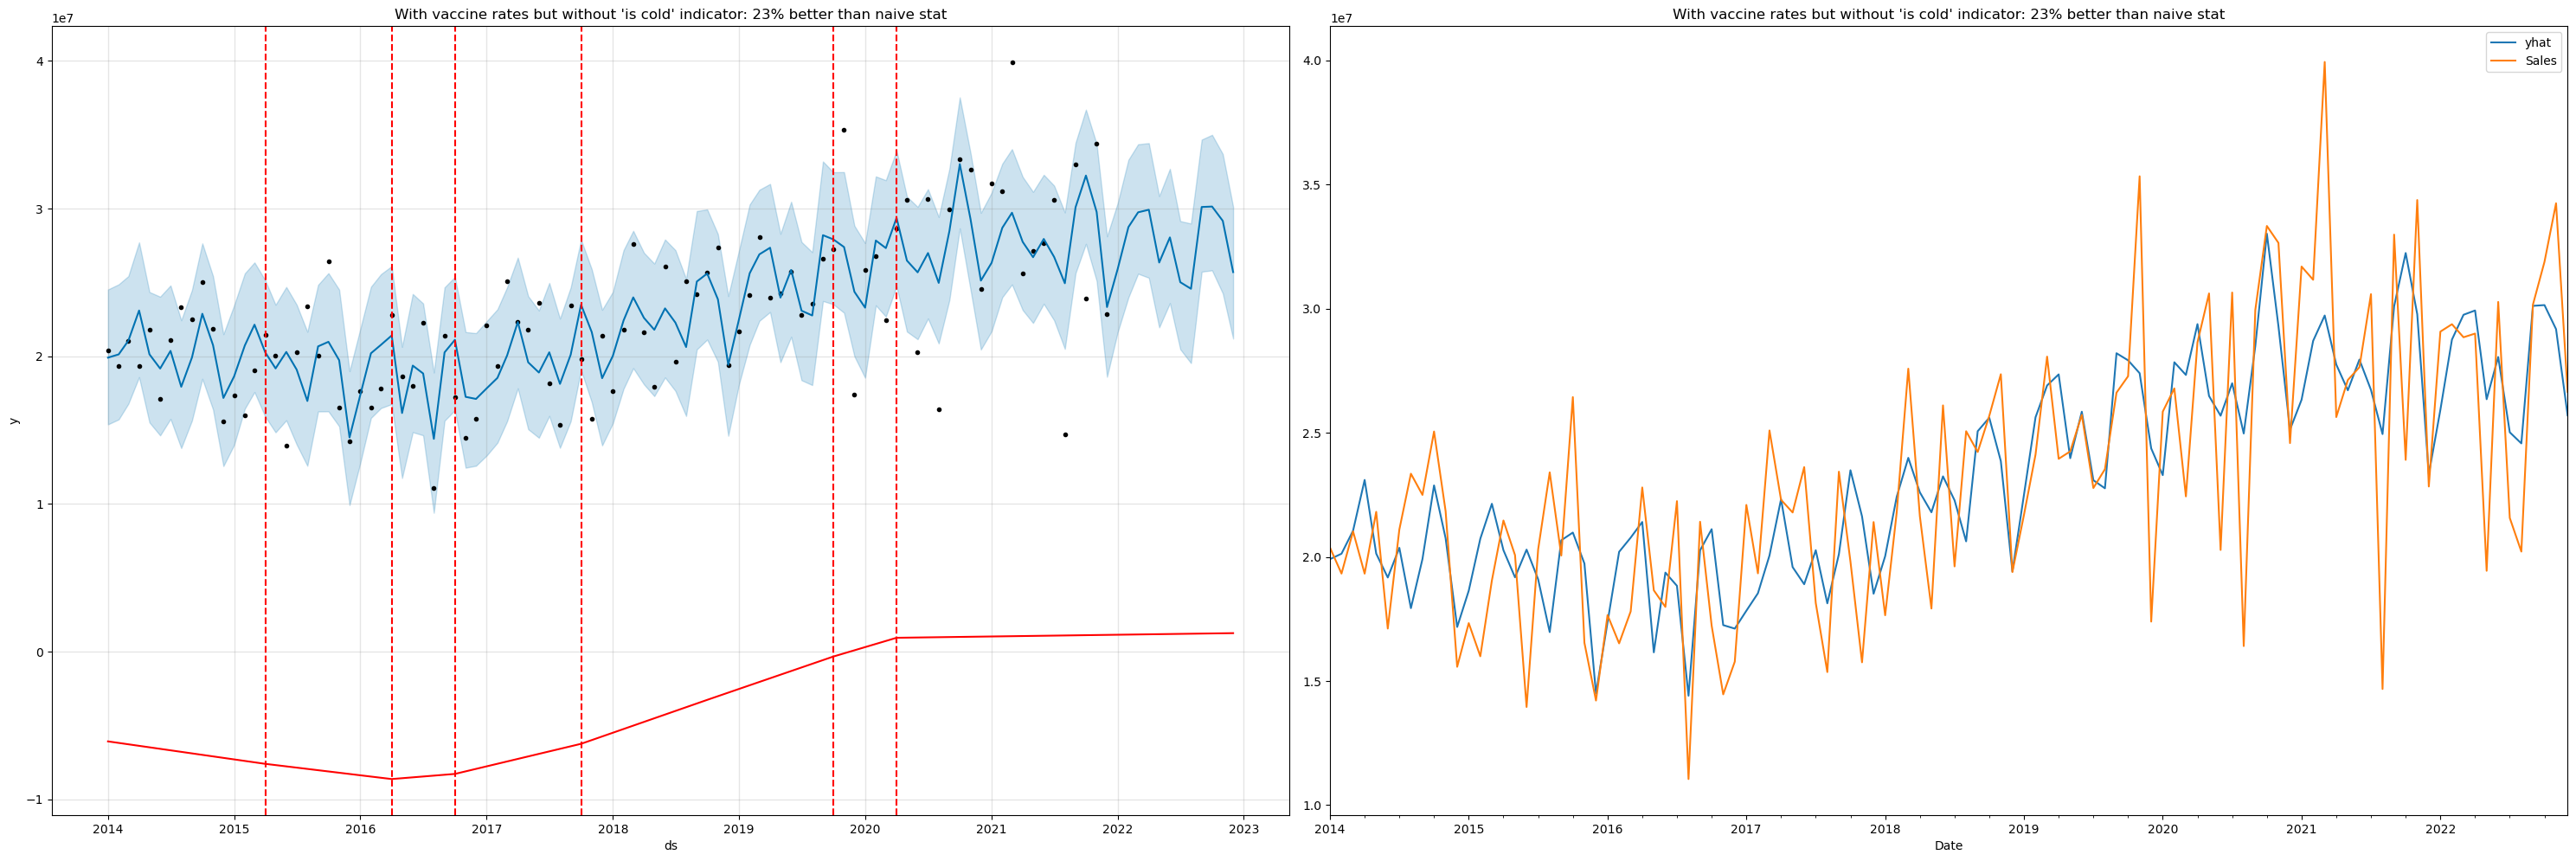

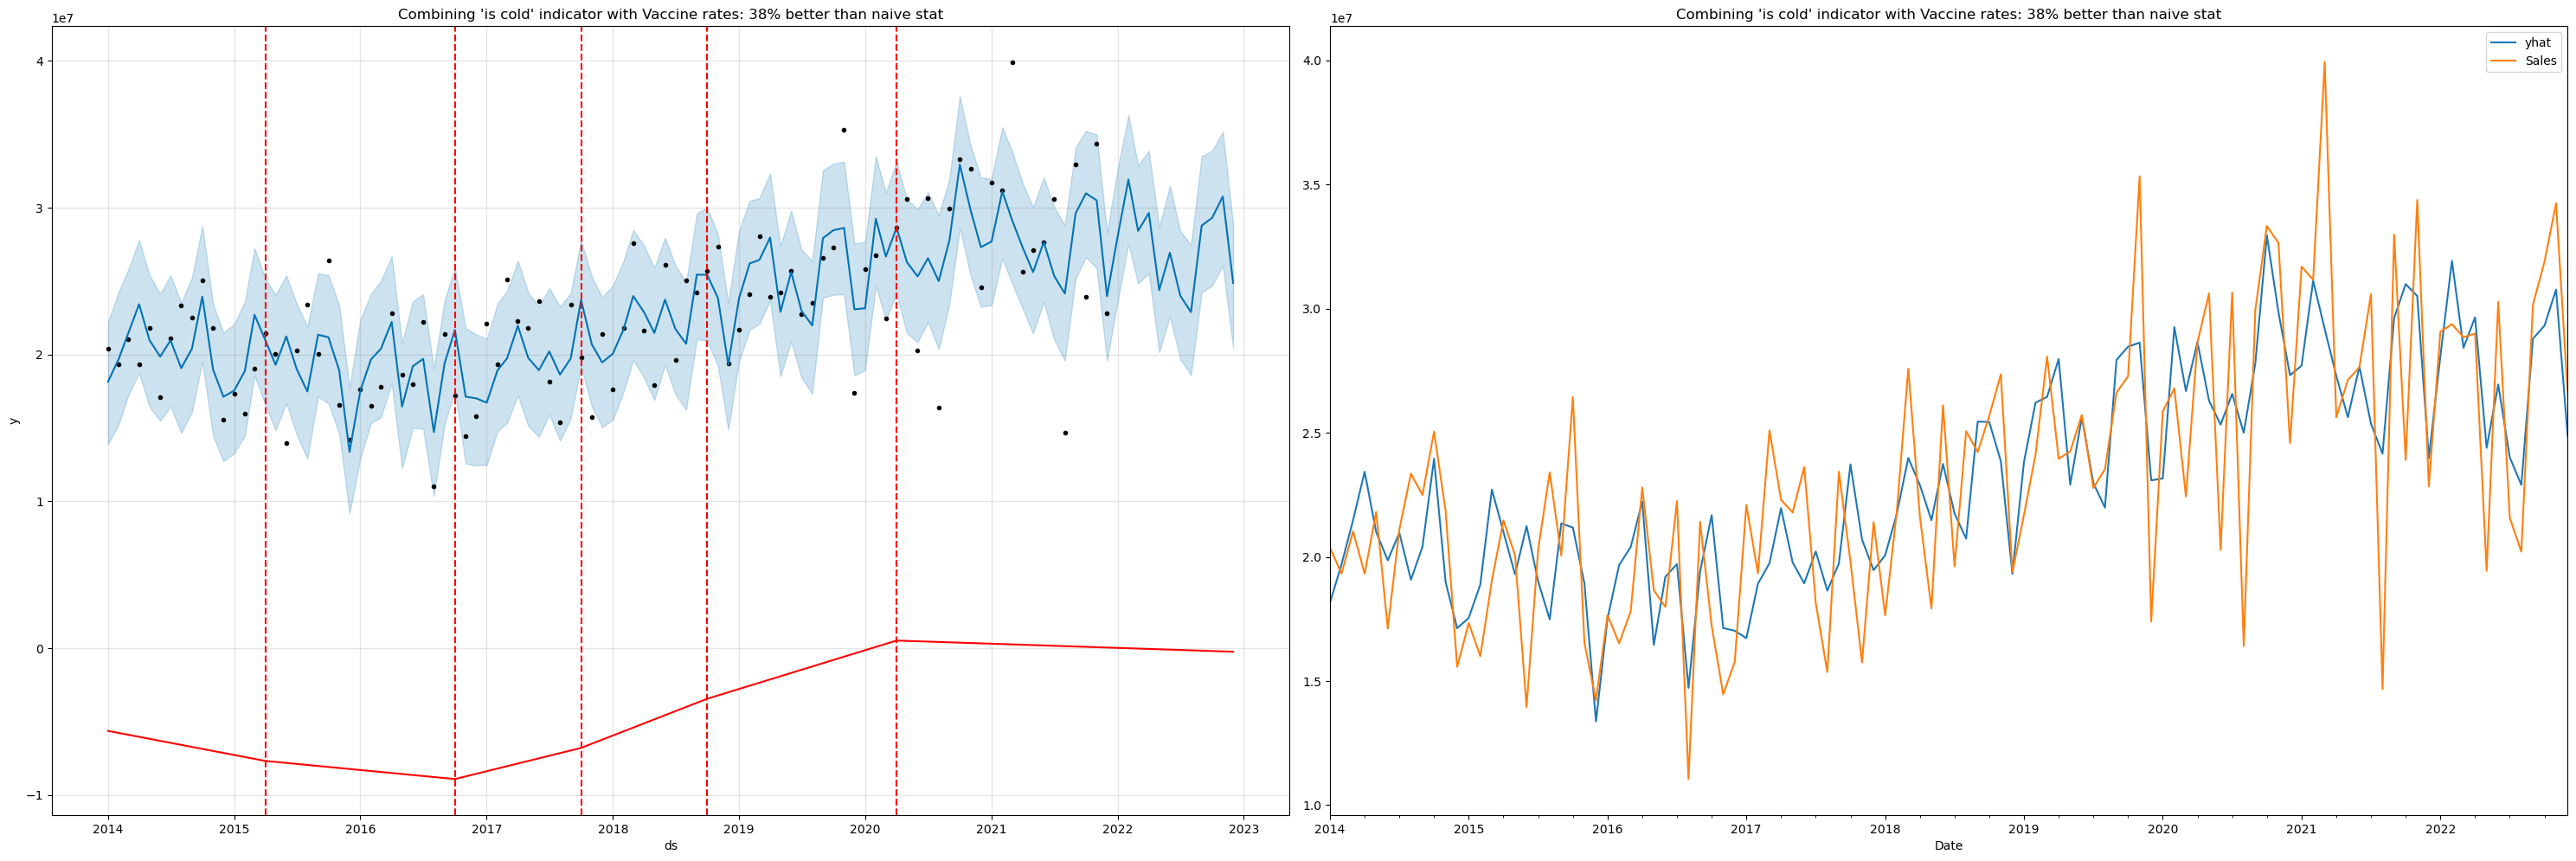

In [23]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import math

def plot_prophet_with_parameters_and_external_regressors(df_sales, df_external = None, plot_components=False, title=None, **kwargs):
        print("Running with configuration:", kwargs)
        fig, axes = plt.subplots(1, 2, figsize=(30, 10))
        if df_external is not None:
                df = pd.concat([df_sales, df_external], axis=1)
        else:
                df = df_sales
        df['ds'] = df.index
        df=df.rename(columns={ 'Sales':'y'})
        df = prepare_time_series(df)

        train_df = df[:-cutoff_train_test]
        test_df = df[-cutoff_train_test:]
        model = create_and_fit_model(train_df, **kwargs)

        future = model.make_future_dataframe(periods=cutoff_train_test, freq = 'MS')
        future['Date'] = future['ds']
        future.set_index('Date', inplace=True)
        if df_external is not None:
                future = prepare_time_series(future, df[df_external.columns])
        else:
                future = prepare_time_series(future)

        forecast = model.predict(future)
        forecast['Date'] = forecast['ds']
        forecast.set_index('Date', inplace=True)
        fig = model.plot(forecast,ax=axes[0])
        if plot_components:
                model.plot_components(forecast)
        add_changepoints_to_plot(axes[0], model, forecast)

        viz_df = train_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')


        viz_df[['yhat']].plot(ax=axes[1])
        df_sales[['Sales']].plot(ax=axes[1])

        ref_err2 = stat_error_value
        err2 = print_mserr(test_df, forecast, ref_err2, 1e99)
        axes[0].set_title(f"{title}: {get_percentage_err(test_df, forecast, ref_err2):.0%} better than naive stat")
        axes[1].set_title(f"{title}: {get_percentage_err(test_df, forecast, ref_err2):.0%} better than naive stat")


df_sales = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')
df_vaccines = pd.read_csv("vaccines.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')

df_vaccines = df_vaccines.set_index('Date')

# restrict additional regressor to same time
df_vaccines = df_vaccines.loc[df_sales.index.min():df_sales.index.max(),:]

kwargs = {
        # Do not change trend frequently
        'changepoint_prior_scale': 1, 
        # NOT ADDING 'is cold' INDICATOR
        'iscold_period': 0, 
        'isnotcold_period': 0, 
        # NOT ADDING REGRESSOR FOR CPI
        'cpi_period': 0, 
        # ADDING REGRESSOR FOR VACCINE
        'vaccine_method': 'multiplicative', 
        'vaccine_period': 1, 
        'vaccine_prior_scale': 5,
        # Seasonality config
        'quarterly_period': 4, 
        'yearly_seasonality': 5,
        'quarterly_fourier_order': 5
        }
plot_prophet_with_parameters_and_external_regressors(
        df_sales,
        df_vaccines[['vaccine']],
        title="Constrain trend, add vaccine rates, quaterly and yearly seasonality only", **kwargs)
kwargs = {
        # Accepting moderate changes in trend
        'changepoint_prior_scale': 2, 
        # NOT ADDING REGRESSOR FOR CPI
        'cpi_period': 0, 
        # NOT ADDING 'is cold' INDICATOR
        'iscold_period': 0,
        'isnotcold_period': 0,
        # ADDING REGRESSOR FOR VACCINE
        'vaccine_method': 'multiplicative',
        'vaccine_period': 1, 
        'vaccine_prior_scale': 4, 
        # Seasonality config
        'quarterly_period': 4,
        'quarterly_fourier_order': 5,
        'yearly_seasonality': 5
        } 
plot_prophet_with_parameters_and_external_regressors(df_sales, df_vaccines[['vaccine']],title="With vaccine rates but without 'is cold' indicator", **kwargs)

kwargs = {
        # Accepting moderate changes in trend
        'changepoint_prior_scale': 2, 
        # NOT ADDING REGRESSOR FOR CPI
        'cpi_period': 0, 
        # ADDING 'is cold' INDICATOR
        'fourier_order_isnotcold': 3, 
        'iscold_fourier_order': 2, 
        'iscold_period': 5, 
        'isnotcold_period': 4, 
        # ADDING REGRESSOR FOR VACCINE
        'vaccine_method': 'multiplicative',
        'vaccine_period': 1, 
        'vaccine_prior_scale': 4, 
        # Seasonality config
        'quarterly_period': 4,
        'quarterly_fourier_order': 5,
        'yearly_seasonality': 5
        } 

# combine best trained model on is cold with vaccine prediction
plot_prophet_with_parameters_and_external_regressors(df_sales, df_vaccines[['vaccine']], title="Combining 'is cold' indicator with Vaccine rates", **kwargs)
# previous best prediction
# df = df_sales.copy()
# df.index = pd.to_datetime(df_sales.index)
# plot_prophet_with_parameters(df, **{'changepoint_prior_scale': 2.5, 'fourier_order_isnotcold': 3, 'iscold_fourier_order': 2, 'iscold_period': 5, 'isnotcold_period': 4, 'quarterly_fourier_order': 1, 'quarterly_period': 1, 'yearly_seasonality': 5})


* Adding vaccine data significantly decreases (15%) the MSE of the time series compared to naive methods.
* This is on top of a 20-25% improvement due to Prophet performance alone, achieving up to 38% better mean square error


20:42:51 - cmdstanpy - INFO - Chain [1] start processing


Running with configuration: {'changepoint_prior_scale': 2.5, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 1, 'iscold_period': 0, 'isnotcold_period': 0, 'quarterly_fourier_order': 2, 'quarterly_period': 2, 'cpi_method': 'multiplicative', 'cpi_period': 0, 'cpi_prior_scale': 0.5, 'vaccine_method': 'multiplicative', 'vaccine_period': 1, 'vaccine_prior_scale': 3, 'yearly_seasonality': 5}


20:42:52 - cmdstanpy - INFO - Chain [1] done processing


error report:
Error using Prophet model: RMSE=3527180.7884010593, MAE=11.26905159741659%
RMSE using Naive prediction (SARIMA) model: 4208130.426976186
RMSE improved by 16.18%


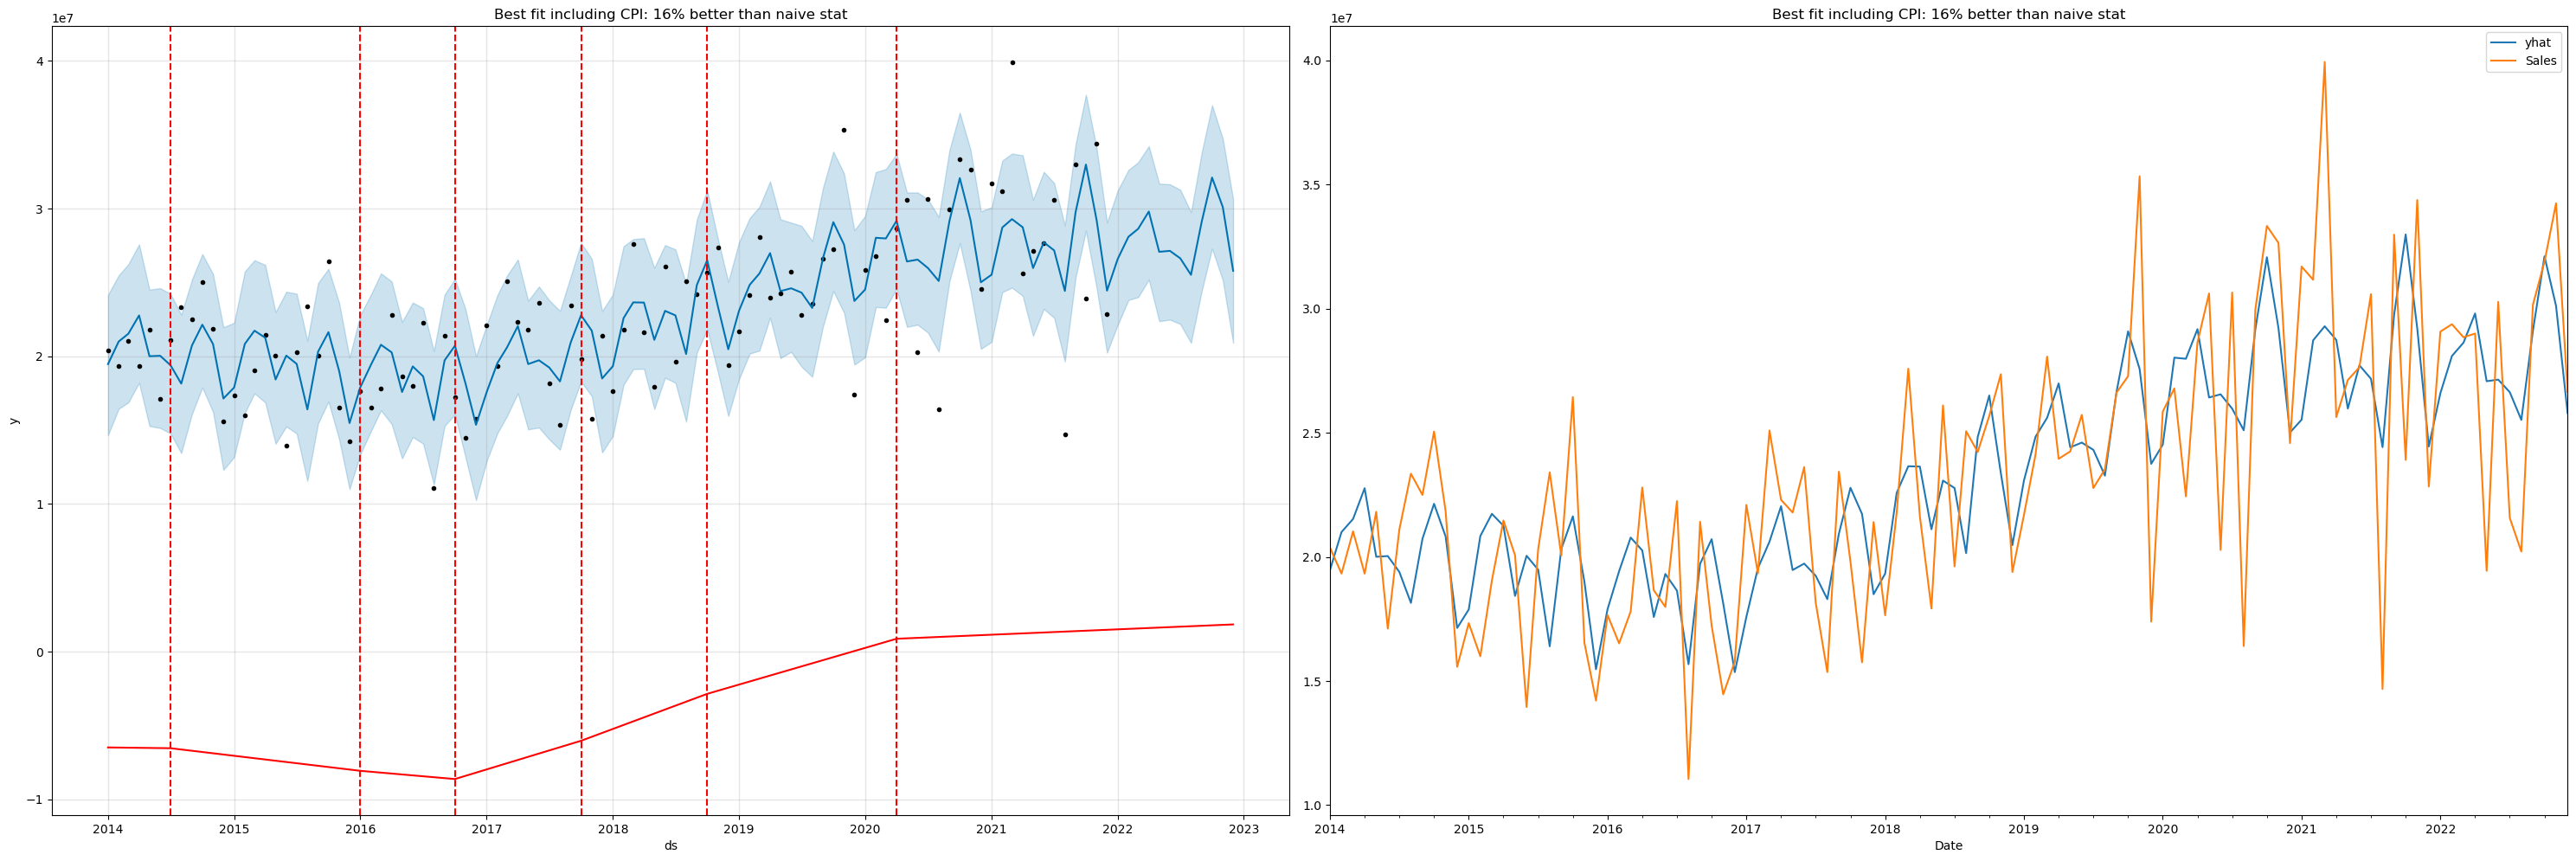

In [24]:
cpi_cz = [1.3, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.5, 0.5, 0.5, 0.4,
          0.3, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.4, 0.4, 0.4, 0.3, 0.3,
          0.4, 0.4, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.4, 0.5, 0.7,
          0.8, 1.0, 1.2, 1.3, 1.5, 1.7, 1.8, 2.0, 2.2, 2.3, 2.4, 2.5,
          2.4, 2.4, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.2, 2.2, 2.1,
          2.2, 2.3, 2.4, 2.4, 2.5, 2.5, 2.6, 2.6, 2.6, 2.7, 2.7, 2.8,
          2.9, 3.0, 3.1, 3.1, 3.1, 3.1, 3.2, 3.2, 3.3, 3.3, 3.2, 3.2,
          3.0, 2.9, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 3.0, 3.2, 3.5, 3.8,
          4.5, 5.2, 6.1, 7.0, 8.1, 9.4, 10.6, 11.7, 12.7, 13.5, 14.4, 15.1,
          15.7, 16.2]
data_cpi = {'Date': pd.date_range(start='2014-01-01', periods=len(cpi_cz), freq='MS'),
        'CPI': cpi_cz}

df_cpi = pd.DataFrame(data_cpi).set_index('Date')
df_cpi = df_cpi.loc[df_sales.index.min():df_sales.index.max(),:]
df = pd.concat([df_vaccines, df_cpi], axis=1)
df['ds'] = df.index
kwargs ={'changepoint_prior_scale': 2.5, 'fourier_order_isnotcold': 2, 'iscold_fourier_order': 1, 'iscold_period': 0, 'isnotcold_period': 0, 'quarterly_fourier_order': 2, 'quarterly_period': 2, 'cpi_method': 'multiplicative', 'cpi_period': 0, 'cpi_prior_scale': 0.5, 'vaccine_method': 'multiplicative', 'vaccine_period': 1, 'vaccine_prior_scale': 3, 'yearly_seasonality': 5} 

plot_prophet_with_parameters_and_external_regressors(
        df_sales,
        df[['vaccine', 'CPI']],
        title="Best fit including CPI", **kwargs)

## Conclusion

The Prophet ML model outperforms the classic statistical model by 18%. It creates a 12-month long seasonal pattern over the trend. This may be because Prophet is able to spot occasional changes in the trend which wouldn't be caught by SARIMA or seasonal decomposition (that's why the series can look like not very seasonal when in fact it has a seasonal component overlayed on a complex trend). 
Adding regressors helps, depending on the choice of regressors. Adding CPI does not provide any upside (Prophet only outperforms SARIMA slightly less - by 16% vs 18% with no additional regressors). Adding vaccine rates from google trends as a single additional regressor (without 'is cold') alone beats any pure-time series prediction. 
Combining all relevant features (vaccines, is cold, pure time series features) beats the naive statistical model by 38%. 

| Model configuration | RMSE | MAE(%) | RMSE Improvement compared to SARIMA |
| --- | --- | --- | --- |
| SARIMA (Best optimized) | 4.2M | 10.15% | basis for comparison |
| Prophet base config (no hints) | 3.9M | 12% | +6% |
| Prophet base config + 'is cold' hint| 3.4M | 11% | +18.80% |
| Prophet base config + additional regressors: CPI + vaccine rate (no hints) | 3.5 | 11.26% | +16.18% |
| Prophet base config + additional regressor: Vaccine rate only (no hints)| 3.2M to 3.3M | 10.5% to 10.3% |+21.37% to +23.26% depending if trend is more or less constrained |
| Prophet base config + additional regressor: Vaccine rate only + 'is cold' hint| 2.6M | 8.86% | +38.44% |

While most of the above analysis has been done with regards to RMSE, it is important to note that SARIMA and Prophet are mostly equivalent in terms of mean absolute error. This means that the prediction somewhat accurately follows ground truth but SARIMA's deviations may be violent at times when Prophet's are more casual.

The same is confirmed when doing a long prediction (24 months instead of 12): SARIMA is similar to Prophet until we add further regressors. In this case it is interesting to note that the impact of CPI is noticable because inflation played a major role in 2021.

| Model configuration | RMSE | MAE(%) | RMSE Improvement compared to SARIMA |
| --- | --- | --- | --- |
| SARIMA (Best optimized) | 7.2M | 19% | basis for comparison |
| Prophet base config + 'is cold' hint| 5.9M | 18% | +19% |
| Prophet base config + additional regressors: CPI + vaccine rate (no hints) | 5.7M | 17% | +21.7% |
| Prophet base config + additional regressor: Vaccine rate only (no hints)| 5.7M | 19%-20% | 20.6% |
| Prophet base config + additional regressor: Vaccine rate only + 'is cold' hint| 5.2M | 15% | +29% |
